# Library Installation


In [ ]:
!pip install pennylane --upgrade
!pip install matplotlib
!pip install scipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 23.8 MB/s eta 0:00:00


#Library Imports


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, entropy
from pennylane import DepolarizingChannel, BitFlip, AmplitudeDamping, PhaseDamping, PhaseFlip
from scipy.special import comb
import copy

# General Distribution Plotting Function

In [ ]:
def plot_distribution(probabilities, title, num_timesteps=None):
    num_outcomes = len(probabilities)
    if num_outcomes > 0:
        num_output_bits = int(np.ceil(np.log2(num_outcomes)))
    else:
        num_output_bits = 0
    outcomes = np.arange(num_outcomes)
    plt.figure(figsize=(10, 6))
    plt.bar(outcomes, probabilities)
    plt.title(title)
    plt.xlabel(f"Output State (Binary for {num_output_bits} bits)")
    plt.ylabel("Probability")
    if num_outcomes <= 16:
        plt.xticks(outcomes, [f"{i:0{num_output_bits}b}" for i in outcomes], rotation=45, ha='right')
    elif num_outcomes <= 64:
        plt.xticks(outcomes[::2], [f"{i:0{num_output_bits}b}" for i in outcomes[::2]], rotation=45, ha='right')
    else:
        plt.xticks(outcomes[::4], [f"{i:0{num_output_bits}b}" for i in outcomes[::4]], rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("Plotting function defined.")

Plotting function defined.


# Quantum Galton Board Circuit


In [ ]:
def quantum_plinko_circuit(num_timesteps, bias_angle_rad, noise_prob_per_gate=0.0):
    total_qubits = 1 + num_timesteps
    dev = qml.device("default.mixed", wires=total_qubits)

    @qml.qnode(dev)
    def circuit():
        decision_wire = 0
        output_wires = list(range(1, total_qubits))

        qml.RY(bias_angle_rad, wires=decision_wire)
        if noise_prob_per_gate > 0:
            qml.DepolarizingChannel(noise_prob_per_gate, wires=decision_wire)

        for t in range(num_timesteps):
            qml.CNOT(wires=[decision_wire, output_wires[t]])
            if noise_prob_per_gate > 0:
                qml.DepolarizingChannel(noise_prob_per_gate, wires=decision_wire)
                qml.DepolarizingChannel(noise_prob_per_gate, wires=output_wires[t])
            qml.RY(bias_angle_rad, wires=decision_wire)
            if noise_prob_per_gate > 0:
                qml.DepolarizingChannel(noise_prob_per_gate, wires=decision_wire)

        return qml.probs(output_wires)

    return circuit()

# Hadamard Quantum Walk Circuit

In [ ]:
def hadamard_quantum_walk_circuit(num_steps, noise_prob_per_gate=0.0):
    coin_wire = 0
    position_wires = list(range(1, num_steps + 1))
    total_qubits = 1 + num_steps

    dev = qml.device("default.mixed", wires=total_qubits)

    @qml.qnode(dev)
    def circuit():
        qml.Hadamard(wires=coin_wire)
        if noise_prob_per_gate > 0:
            qml.DepolarizingChannel(noise_prob_per_gate, wires=coin_wire)

        for s in range(num_steps):
            qml.Hadamard(wires=coin_wire)
            if noise_prob_per_gate > 0:
                qml.DepolarizingChannel(noise_prob_per_gate, wires=coin_wire)

            qml.CNOT(wires=[coin_wire, position_wires[s]])
            if noise_prob_per_gate > 0:
                qml.DepolarizingChannel(noise_prob_per_gate, wires=coin_wire)
                qml.DepolarizingChannel(noise_prob_per_gate, wires=position_wires[s])

            if noise_prob_per_gate > 0:
                qml.DepolarizingChannel(noise_prob_per_gate, wires=coin_wire)
                qml.DepolarizingChannel(noise_prob_per_gate, wires=position_wires[s])

        return qml.probs(position_wires)

    return circuit()

# Binomial Distribution Plotting Function

In [ ]:
def plot_binomial_distribution(probabilities, num_timesteps, title):
    if num_timesteps == 0:
        print("Cannot plot binomial distribution for 0 timesteps.")
        return

    sum_probabilities = np.zeros(num_timesteps + 1)

    for i in range(len(probabilities)):
        num_ones = bin(i).count('1')
        sum_probabilities[num_ones] += probabilities[i]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(np.arange(num_timesteps + 1), sum_probabilities)
    plt.title(title)
    plt.xlabel("Number of '1's (i.e., Number of Right Turns / Final Slot Sum)")
    plt.ylabel("Probability")
    plt.xticks(np.arange(num_timesteps + 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars:
        yval = bar.get_height()
        if yval > 0.001:
            plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 3), va='bottom', ha='center', fontsize=8)

    plt.tight_layout()
    plt.show()

# Expo State Preparation Circuit

In [ ]:
def exponential_state_preparation(num_qubits, decay_rate):
    x_values = np.arange(2**num_qubits)
    prob_dist = np.exp(-decay_rate * x_values)
    prob_dist /= np.sum(prob_dist)

    dev = qml.device("default.qubit", wires=num_qubits)
    @qml.qnode(dev)
    def circuit():
        qml.MottonenStatePreparation(np.sqrt(prob_dist), wires=range(num_qubits))
        return qml.probs(wires=range(num_qubits))

    return prob_dist, circuit()

def measure_exponential_distribution(num_qubits, decay_rate):
    target_prob_dist, _ = exponential_state_preparation(num_qubits, decay_rate)

    dev = qml.device("default.qubit", wires=num_qubits, shots=10000)

    @qml.qnode(dev)
    def circuit():
        x_values = np.arange(2**num_qubits)
        prob_dist_circuit = np.exp(-decay_rate * x_values)
        prob_dist_circuit /= np.sum(prob_dist_circuit)
        qml.MottonenStatePreparation(np.sqrt(prob_dist_circuit), wires=range(num_qubits))
        return qml.sample(wires=range(num_qubits))

    measured_samples = circuit()

    num_outcomes = 2**num_qubits
    measured_probs = np.zeros(num_outcomes)
    unique_samples, counts = np.unique(measured_samples, axis=0, return_counts=True)
    for i, sample in enumerate(unique_samples):
        int_val = int("".join(str(int(bit)) for bit in sample), 2)
        measured_probs[int_val] = counts[i] / len(measured_samples)

    return target_prob_dist, measured_probs

# Distance Metric Calculation Functions


In [ ]:
def calculate_fidelity(prob_dist1, prob_dist2):
    if len(prob_dist1) != len(prob_dist2):
        raise ValueError("Distributions must have the same number of outcomes.")
    prob_dist1 = np.maximum(prob_dist1, 0)
    prob_dist2 = np.maximum(prob_dist2, 0)
    fidelity = (np.sum(np.sqrt(prob_dist1 * prob_dist2)))**2
    return fidelity

def calculate_hellinger_distance(prob_dist1, prob_dist2):
    if len(prob_dist1) != len(prob_dist2):
        raise ValueError("Distributions must have the same number of outcomes.")
    prob_dist1 = np.maximum(prob_dist1, 0)
    prob_dist2 = np.maximum(prob_dist2, 0)
    hellinger_dist = np.sqrt(np.sum((np.sqrt(prob_dist1) - np.sqrt(prob_dist2))**2)) / np.sqrt(2)
    return hellinger_dist

def calculate_kullback_leibler_divergence(prob_dist_p, prob_dist_q):
    if len(prob_dist_p) != len(prob_dist_q):
        raise ValueError("Distributions must have the same number of outcomes.")
    epsilon = 1e-10
    prob_dist_p = np.maximum(prob_dist_p, epsilon)
    prob_dist_q = np.maximum(prob_dist_q, epsilon)
    kl_div = entropy(prob_dist_p, qk=prob_dist_q)
    return kl_div

def calculate_total_variation_distance(prob_dist1, prob_dist2):
    if len(prob_dist1) != len(prob_dist2):
        raise ValueError("Distributions must have the same number of outcomes.")
    tvd = 0.5 * np.sum(np.abs(prob_dist1 - prob_dist2))
    return tvd

print("Distance metric functions defined.")

Distance metric functions defined.


# Noiseless quantum circuit for amplitude encoding


--- Noiseless Exponential Distribution Verification ---


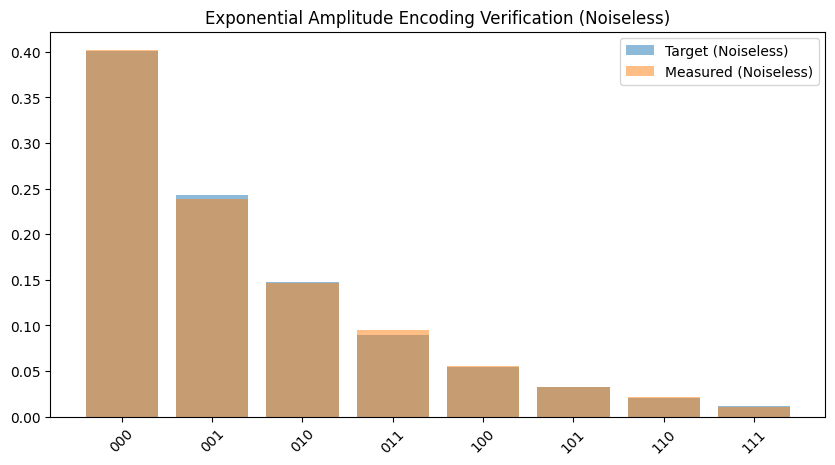


Exponential Distribution (Amplitude Encoding - Noiseless) Distances:
  Fidelity: 0.9998
  Hellinger Distance: 0.0107
  KL Divergence: 0.0005
  Total Variation Distance: 0.0089


In [ ]:
print("\n--- Noiseless Exponential Distribution Verification ---")
target_probs_noiseless_exp, measured_probs_noiseless_exp = measure_exponential_distribution(3, 0.5)

plt.figure(figsize=(10, 5))
plt.bar(range(8), target_probs_noiseless_exp, alpha=0.5, label="Target (Noiseless)")
plt.bar(range(8), measured_probs_noiseless_exp, alpha=0.5, label="Measured (Noiseless)")
plt.xticks(range(8), [f"{i:03b}" for i in range(8)], rotation=45)
plt.legend()
plt.title("Exponential Amplitude Encoding Verification (Noiseless)")
plt.show()

fidelity_exp_noiseless = calculate_fidelity(target_probs_noiseless_exp, measured_probs_noiseless_exp)
hellinger_exp_noiseless = calculate_hellinger_distance(target_probs_noiseless_exp, measured_probs_noiseless_exp)
kl_div_exp_noiseless = calculate_kullback_leibler_divergence(measured_probs_noiseless_exp, target_probs_noiseless_exp)
tvd_exp_noiseless = calculate_total_variation_distance(target_probs_noiseless_exp, measured_probs_noiseless_exp)

print("\nExponential Distribution (Amplitude Encoding - Noiseless) Distances:")
print(f"  Fidelity: {fidelity_exp_noiseless:.4f}")
print(f"  Hellinger Distance: {hellinger_exp_noiseless:.4f}")
print(f"  KL Divergence: {kl_div_exp_noiseless:.4f}")
print(f"  Total Variation Distance: {tvd_exp_noiseless:.4f}")

# Expo State Preparation with Noise



--- Exponential Distribution with Noise ---


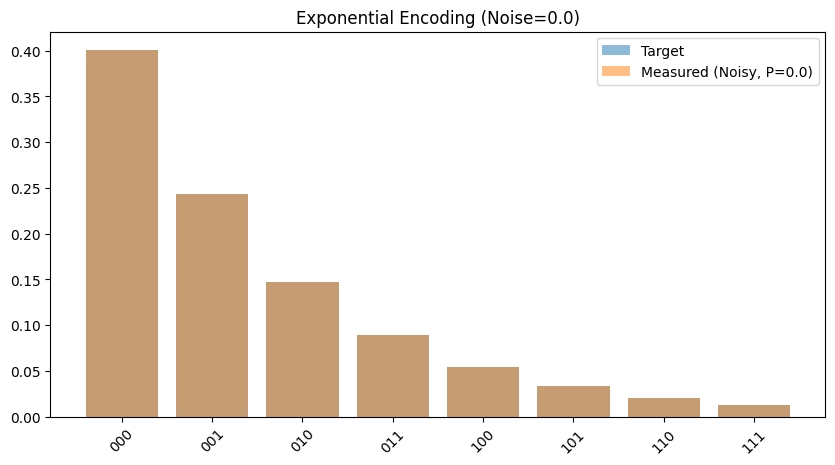


Exponential Distribution (Noise=0.0) Distances:
  Fidelity: 1.0000
  Hellinger Distance: 0.0000
  KL Divergence: -0.0000
  Total Variation Distance: 0.0000


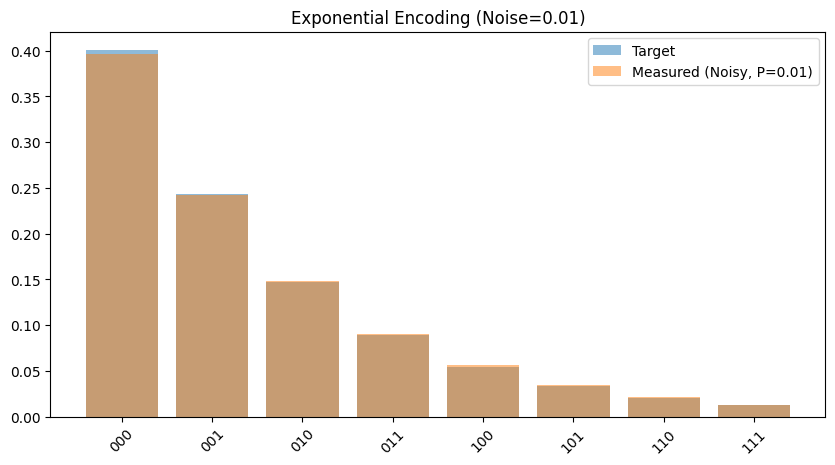


Exponential Distribution (Noise=0.01) Distances:
  Fidelity: 0.9999
  Hellinger Distance: 0.0061
  KL Divergence: 0.0002
  Total Variation Distance: 0.0064


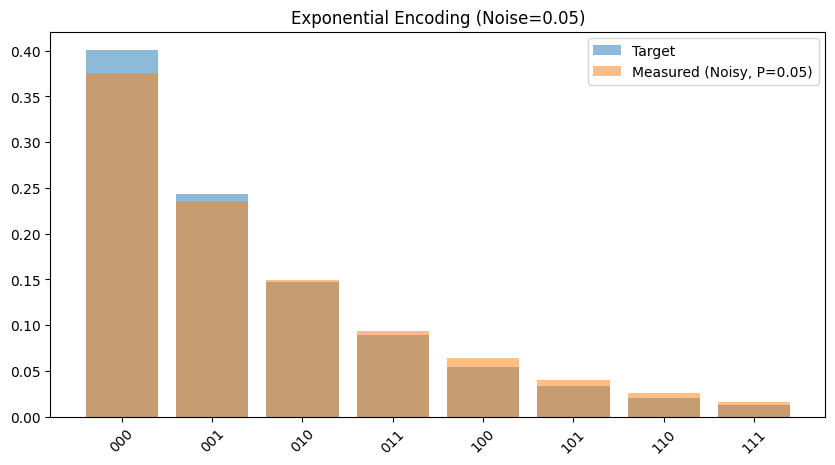


Exponential Distribution (Noise=0.05) Distances:
  Fidelity: 0.9982
  Hellinger Distance: 0.0298
  KL Divergence: 0.0036
  Total Variation Distance: 0.0317


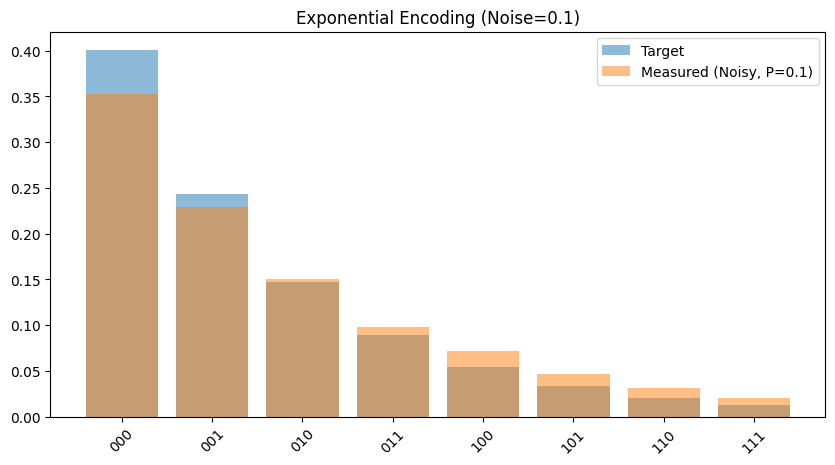


Exponential Distribution (Noise=0.1) Distances:
  Fidelity: 0.9933
  Hellinger Distance: 0.0578
  KL Divergence: 0.0140
  Total Variation Distance: 0.0627


In [ ]:
def exponential_state_preparation_with_noise(num_qubits, decay_rate, noise_prob_per_qubit=0.0):
    x_values = np.arange(2**num_qubits)
    prob_dist = np.exp(-decay_rate * x_values)
    prob_dist /= np.sum(prob_dist)

    dev = qml.device("default.mixed", wires=num_qubits)

    @qml.qnode(dev)
    def circuit():
        qml.MottonenStatePreparation(np.sqrt(prob_dist), wires=range(num_qubits))

        if noise_prob_per_qubit > 0:
            for w in range(num_qubits):
                qml.DepolarizingChannel(noise_prob_per_qubit, wires=w)

        return qml.probs(wires=range(num_qubits))

    measured_probs = circuit()
    return prob_dist, measured_probs

print("\n--- Exponential Distribution with Noise ---")
decay_rate = 0.5
num_qubits_exp = 3

noise_levels_exp = [0.0, 0.01, 0.05, 0.1]

for noise_prob_exp in noise_levels_exp:
    target_probs_exp_noisy, measured_probs_exp_noisy = exponential_state_preparation_with_noise(
        num_qubits=num_qubits_exp, decay_rate=decay_rate, noise_prob_per_qubit=noise_prob_exp
    )

    plt.figure(figsize=(10, 5))
    plt.bar(range(2**num_qubits_exp), target_probs_exp_noisy, alpha=0.5, label="Target")
    plt.bar(range(2**num_qubits_exp), measured_probs_exp_noisy, alpha=0.5, label=f"Measured (Noisy, P={noise_prob_exp})")
    plt.xticks(range(2**num_qubits_exp), [f"{i:0{num_qubits_exp}b}" for i in range(2**num_qubits_exp)], rotation=45)
    plt.legend()
    plt.title(f"Exponential Encoding (Noise={noise_prob_exp})")
    plt.show()

    fidelity_exp_noisy = calculate_fidelity(target_probs_exp_noisy, measured_probs_exp_noisy)
    hellinger_exp_noisy = calculate_hellinger_distance(target_probs_exp_noisy, measured_probs_exp_noisy)
    kl_div_exp_noisy = calculate_kullback_leibler_divergence(measured_probs_exp_noisy, target_probs_exp_noisy)
    tvd_exp_noisy = calculate_total_variation_distance(target_probs_exp_noisy, measured_probs_exp_noisy)

    print(f"\nExponential Distribution (Noise={noise_prob_exp}) Distances:")
    print(f"  Fidelity: {fidelity_exp_noisy:.4f}")
    print(f"  Hellinger Distance: {hellinger_exp_noisy:.4f}")
    print(f"  KL Divergence: {kl_div_exp_noisy:.4f}")
    print(f"  Total Variation Distance: {tvd_exp_noisy:.4f}")

# Circuit depiction without Noise



--- Challenge 1 & 2: Generalize & Change Distributions ---

--- Unbiased Plinko (Approximates Gaussian distribution for num_timesteps outputs) ---
Timesteps: 2, Probs (raw output qubits): [0.25 0.25 0.25 0.25]


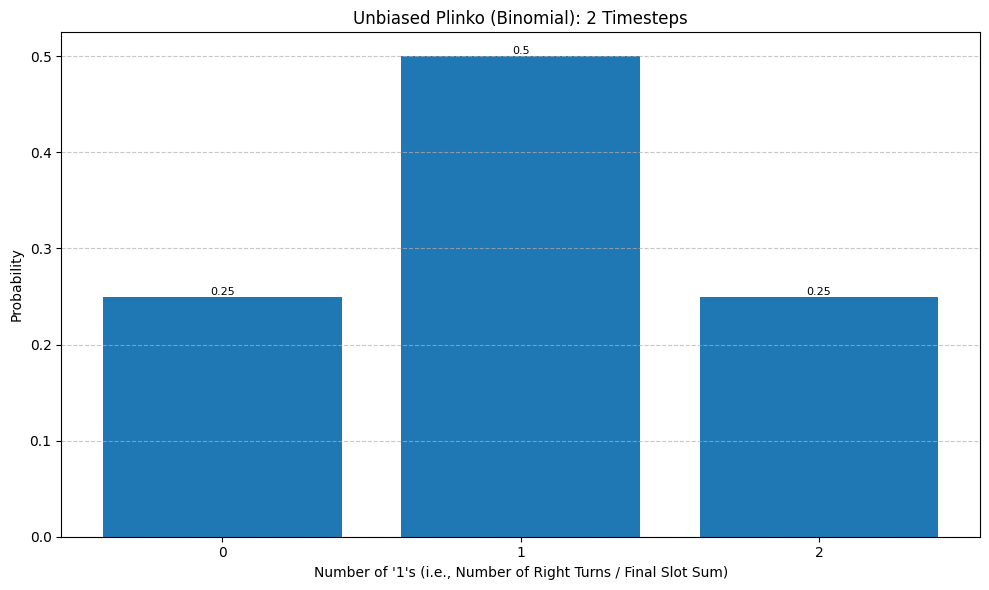

Timesteps: 4, Probs (raw output qubits): [0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]


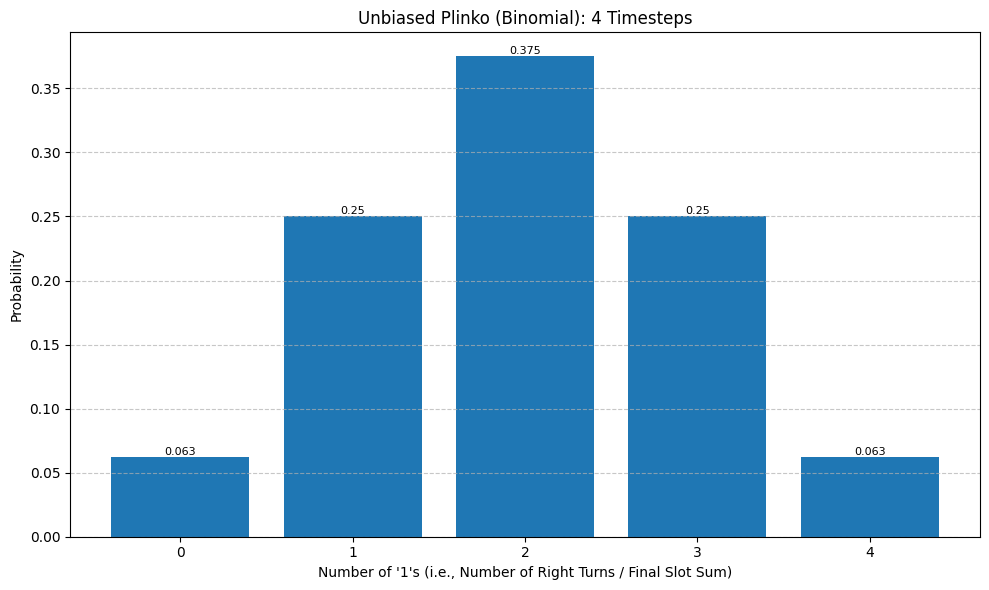

Timesteps: 6, Probs (raw output qubits): [0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625]


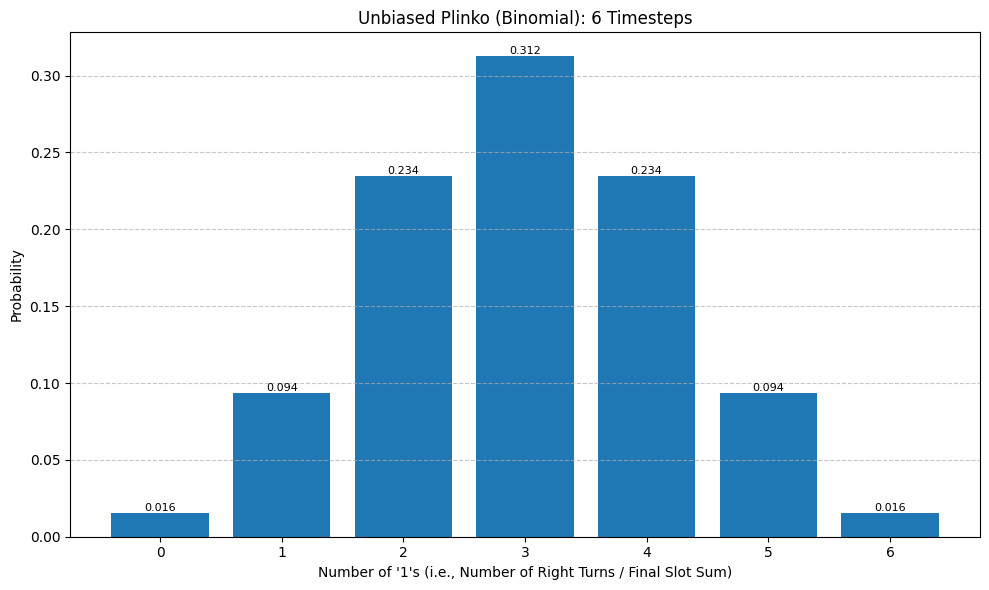

Timesteps: 10, Probs (raw output qubits): [0.00097656 0.00097656 0.00097656 ... 0.00097656 0.00097656 0.00097656]


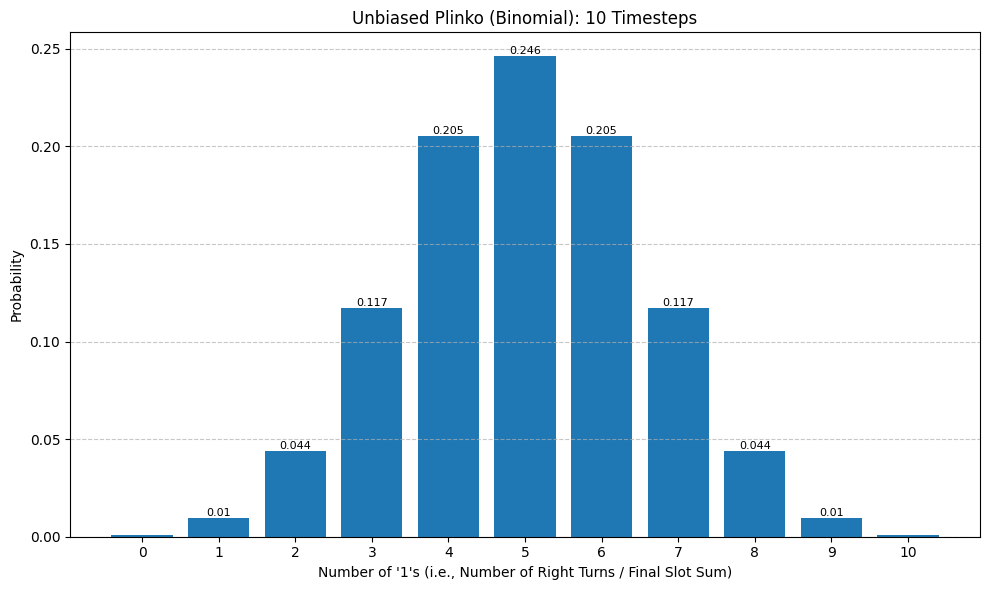


--- Biased Plinko (Skewed Distribution) ---
4 Timesteps, Bias angle pi/4: Probs (raw output qubits): [5.30790043e-01 9.10691738e-02 1.56250000e-02 9.10691738e-02
 1.56250000e-02 2.68082618e-03 1.56250000e-02 9.10691738e-02
 1.56250000e-02 2.68082618e-03 4.59957055e-04 2.68082618e-03
 1.56250000e-02 2.68082618e-03 1.56250000e-02 9.10691738e-02]


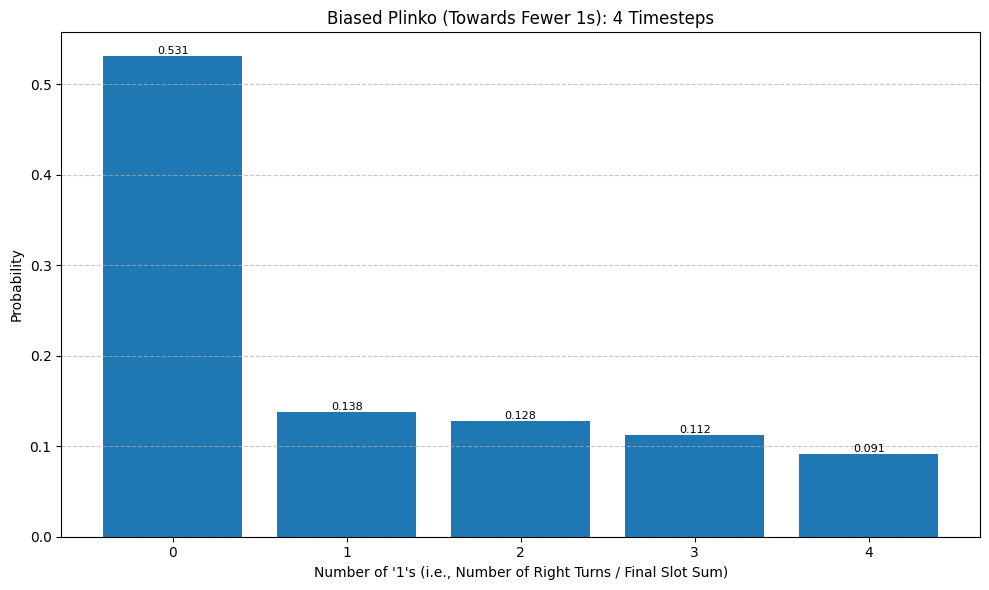

4 Timesteps, Bias angle 3*pi/4: Probs (raw output qubits): [4.59957055e-04 2.68082618e-03 1.56250000e-02 2.68082618e-03
 1.56250000e-02 9.10691738e-02 1.56250000e-02 2.68082618e-03
 1.56250000e-02 9.10691738e-02 5.30790043e-01 9.10691738e-02
 1.56250000e-02 9.10691738e-02 1.56250000e-02 2.68082618e-03]


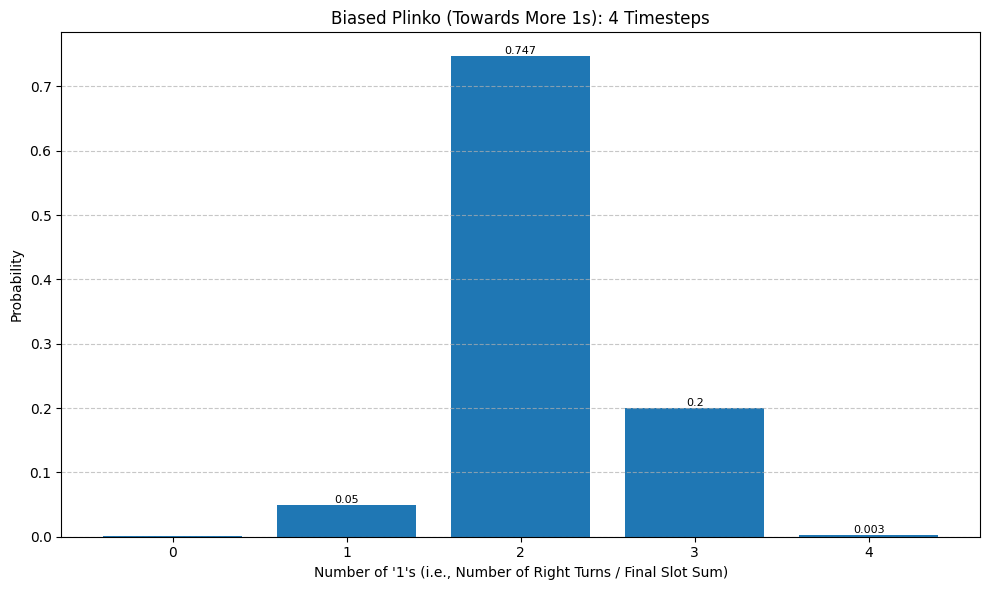

4 Timesteps, Bias angle 0 (Deterministic All 0s): Probs (raw output qubits): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


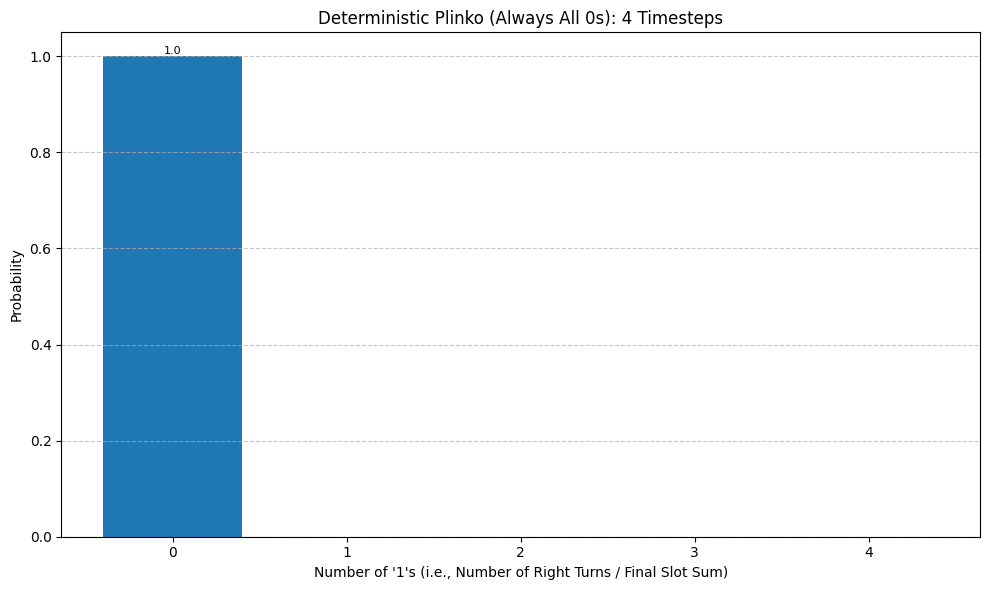

4 Timesteps, Bias angle pi (Deterministic All 1s): Probs (raw output qubits): [1.97627260e-130 5.27090436e-098 1.40579963e-065 5.27090436e-098
 1.40579963e-065 3.74939946e-033 1.40579963e-065 5.27090436e-098
 1.40579963e-065 3.74939946e-033 1.00000000e+000 3.74939946e-033
 1.40579963e-065 3.74939946e-033 1.40579963e-065 5.27090436e-098]


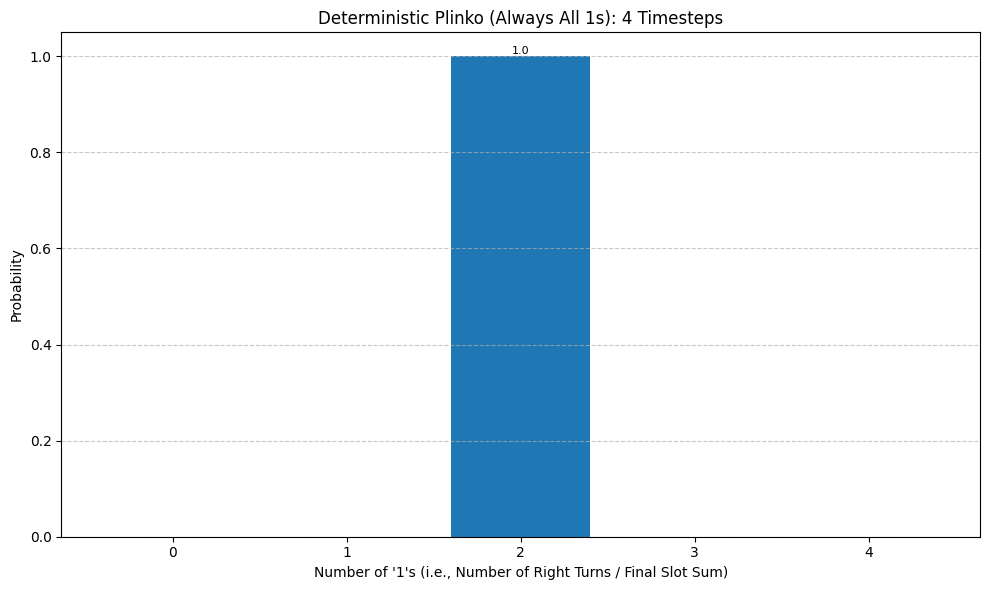


--- Hadamard Quantum Walk Distribution ---

Running Hadamard Quantum Walk for 2 steps...


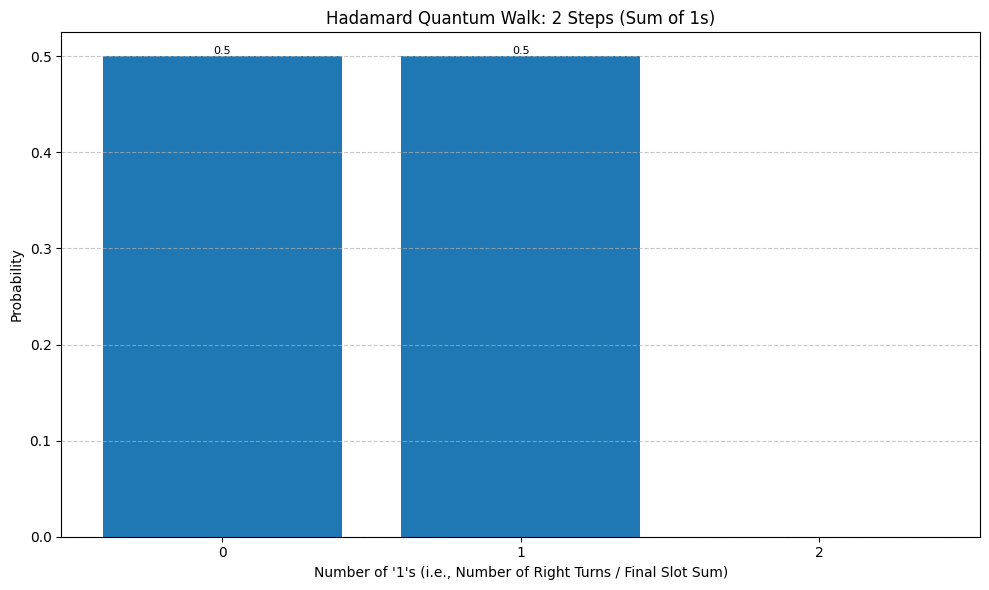


Running Hadamard Quantum Walk for 3 steps...


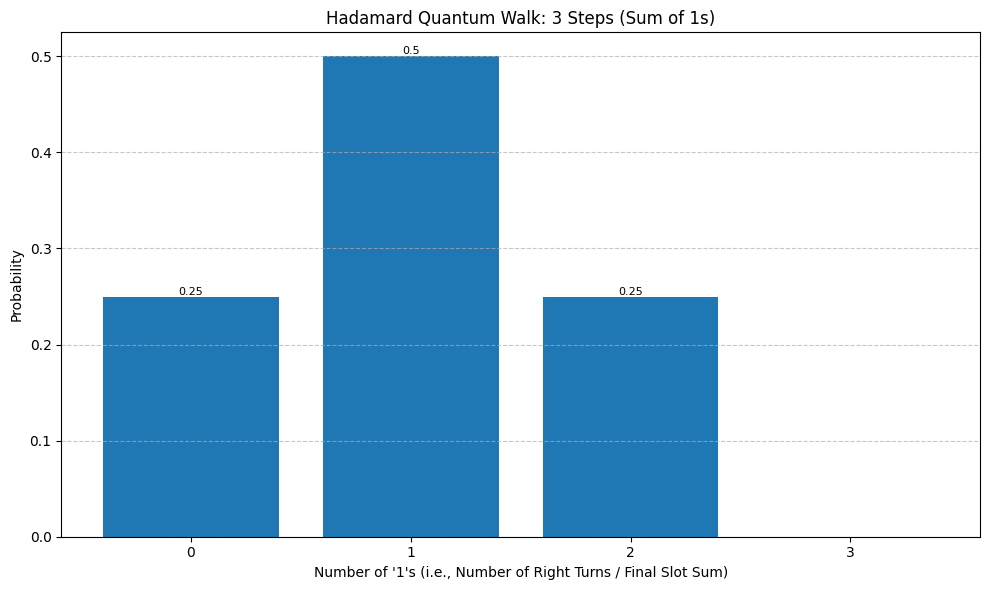


Running Hadamard Quantum Walk for 4 steps...


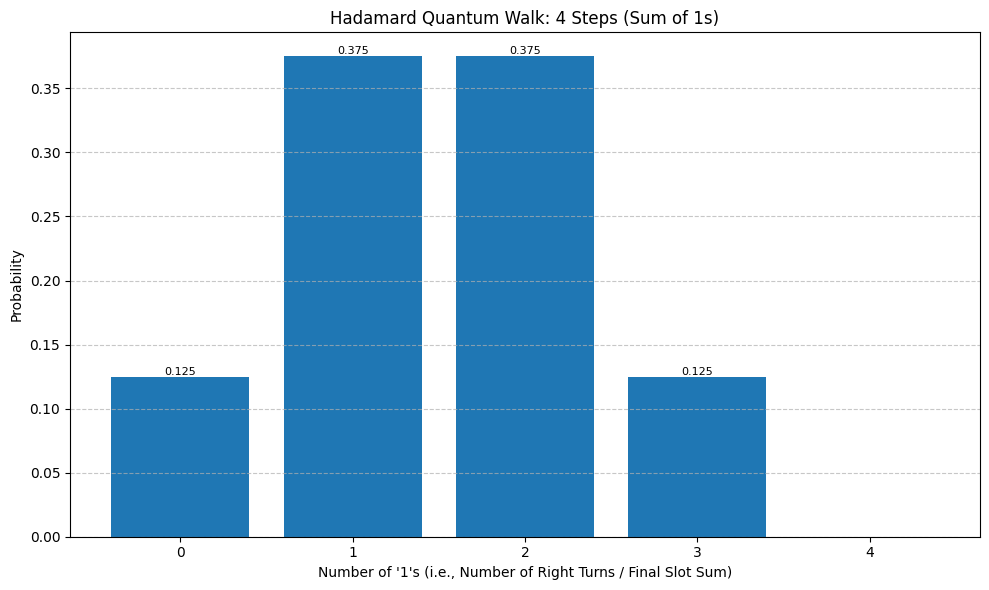


Challenge 1 & 2 execution complete.


In [ ]:
print("\n--- Challenge 1 & 2: Generalize & Change Distributions ---")

print("\n--- Unbiased Plinko (Approximates Gaussian distribution for num_timesteps outputs) ---")
unbiased_timesteps_to_test = [2, 4, 6, 10]
for timesteps in unbiased_timesteps_to_test:
    probs = quantum_plinko_circuit(timesteps, bias_angle_rad=np.pi/2, noise_prob_per_gate=0.0)
    print(f"Timesteps: {timesteps}, Probs (raw output qubits): {probs}")
    plot_binomial_distribution(probs, timesteps, f"Unbiased Plinko (Binomial): {timesteps} Timesteps")


print("\n--- Biased Plinko (Skewed Distribution) ---")
num_timesteps_for_bias_demo = 4

bias_angle_towards_0 = np.pi / 4
probs_biased_0 = quantum_plinko_circuit(num_timesteps_for_bias_demo, bias_angle_towards_0, noise_prob_per_gate=0.0)
print(f"{num_timesteps_for_bias_demo} Timesteps, Bias angle pi/4: Probs (raw output qubits): {probs_biased_0}")
plot_binomial_distribution(probs_biased_0, num_timesteps_for_bias_demo, f"Biased Plinko (Towards Fewer 1s): {num_timesteps_for_bias_demo} Timesteps")

bias_angle_towards_1 = 3 * np.pi / 4
probs_biased_1 = quantum_plinko_circuit(num_timesteps_for_bias_demo, bias_angle_towards_1, noise_prob_per_gate=0.0)
print(f"{num_timesteps_for_bias_demo} Timesteps, Bias angle 3*pi/4: Probs (raw output qubits): {probs_biased_1}")
plot_binomial_distribution(probs_biased_1, num_timesteps_for_bias_demo, f"Biased Plinko (Towards More 1s): {num_timesteps_for_bias_demo} Timesteps")

bias_angle_det_0 = 0
probs_det_0 = quantum_plinko_circuit(num_timesteps_for_bias_demo, bias_angle_det_0, noise_prob_per_gate=0.0)
print(f"{num_timesteps_for_bias_demo} Timesteps, Bias angle 0 (Deterministic All 0s): Probs (raw output qubits): {probs_det_0}")
plot_binomial_distribution(probs_det_0, num_timesteps_for_bias_demo, f"Deterministic Plinko (Always All 0s): {num_timesteps_for_bias_demo} Timesteps")

bias_angle_det_1 = np.pi
probs_det_1 = quantum_plinko_circuit(num_timesteps_for_bias_demo, bias_angle_det_1, noise_prob_per_gate=0.0)
print(f"{num_timesteps_for_bias_demo} Timesteps, Bias angle pi (Deterministic All 1s): Probs (raw output qubits): {probs_det_1}")
plot_binomial_distribution(probs_det_1, num_timesteps_for_bias_demo, f"Deterministic Plinko (Always All 1s): {num_timesteps_for_bias_demo} Timesteps")


print("\n--- Hadamard Quantum Walk Distribution ---")
for steps_qw in [2, 3, 4]:
    print(f"\nRunning Hadamard Quantum Walk for {steps_qw} steps...")
    try:
        qw_probs_raw = hadamard_quantum_walk_circuit(steps_qw, noise_prob_per_gate=0.0)
        plot_binomial_distribution(qw_probs_raw, steps_qw, f"Hadamard Quantum Walk: {steps_qw} Steps (Sum of 1s)")
    except Exception as e:
        print(f"Error running Hadamard Quantum Walk for {steps_qw} steps: {e}")

print("\nChallenge 1 & 2 execution complete.")





# Noise Model Analysis



--- Challenge 3: Noise Model Analysis (Plinko) ---

Testing different noise levels with 4 timesteps (Unbiased Plinko):
Noiseless Target Binomial Probs (4 timesteps): [0.0625 0.25   0.375  0.25   0.0625]


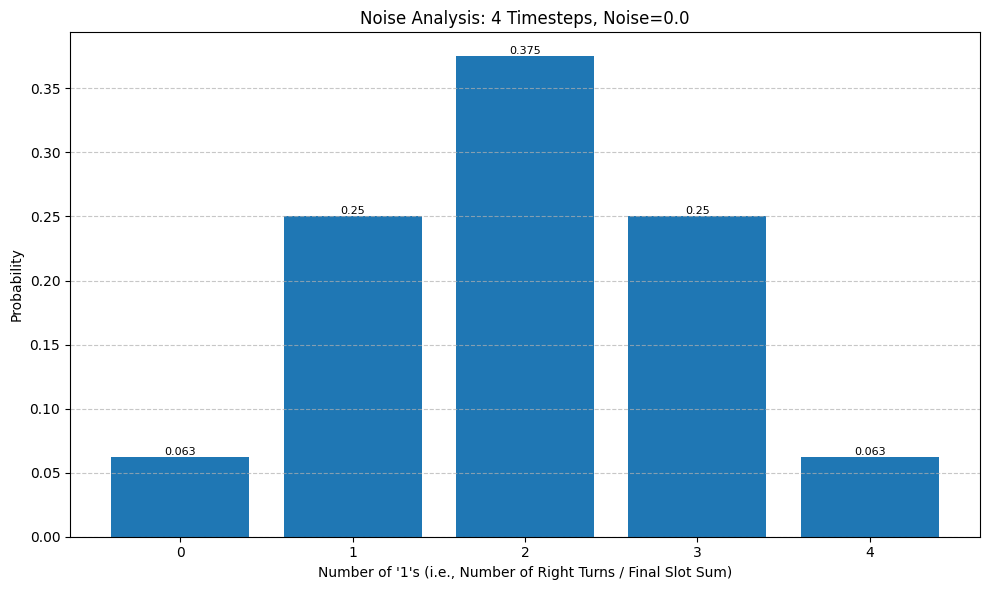

  Noise=0.0:
    Fidelity: 1.0000
    Hellinger Distance: 0.0000
    KL Divergence: 0.0000
    Total Variation Distance: 0.0000


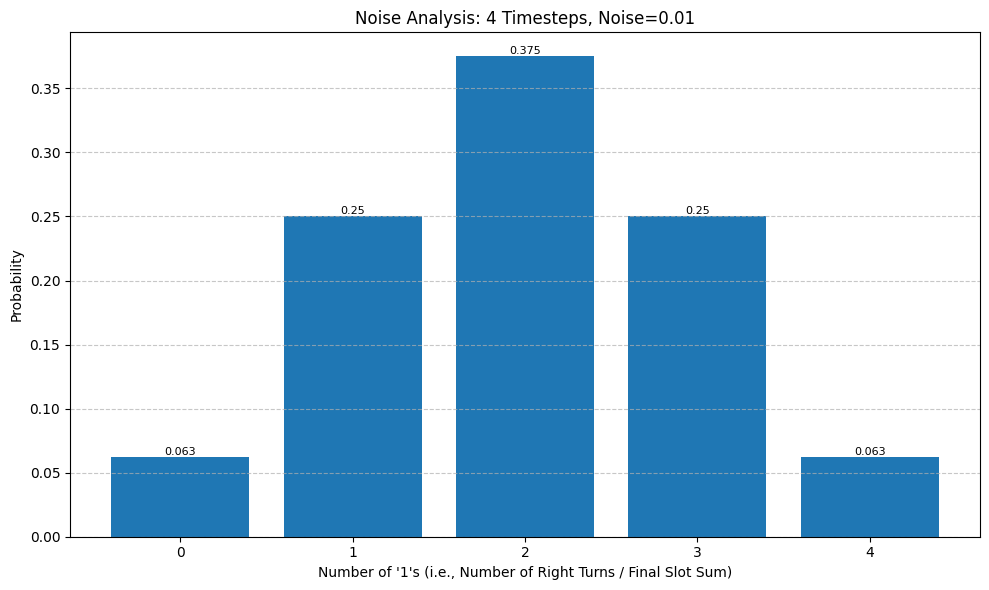

  Noise=0.01:
    Fidelity: 1.0000
    Hellinger Distance: 0.0000
    KL Divergence: 0.0000
    Total Variation Distance: 0.0000


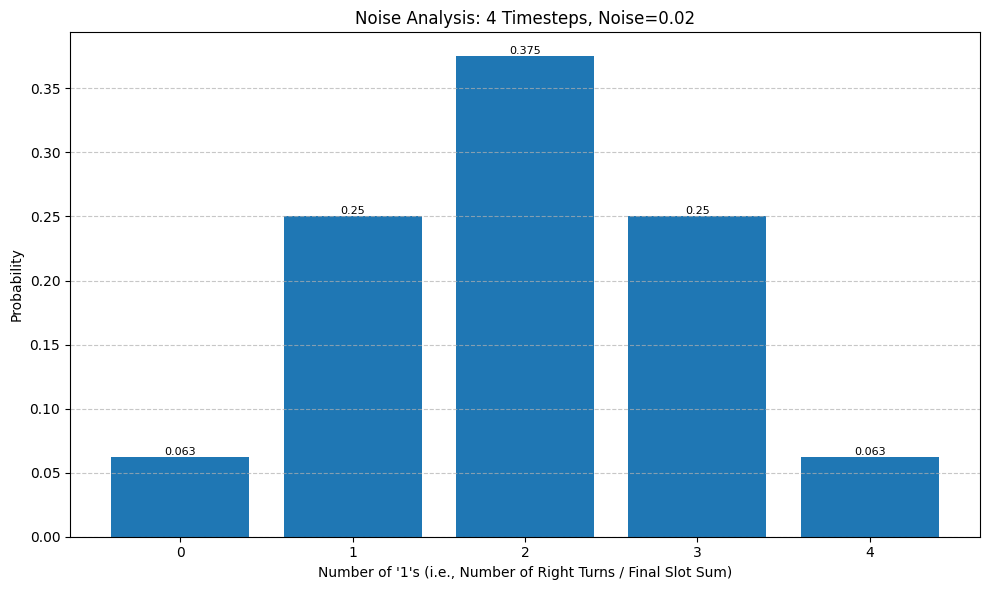

  Noise=0.02:
    Fidelity: 1.0000
    Hellinger Distance: 0.0000
    KL Divergence: 0.0000
    Total Variation Distance: 0.0000


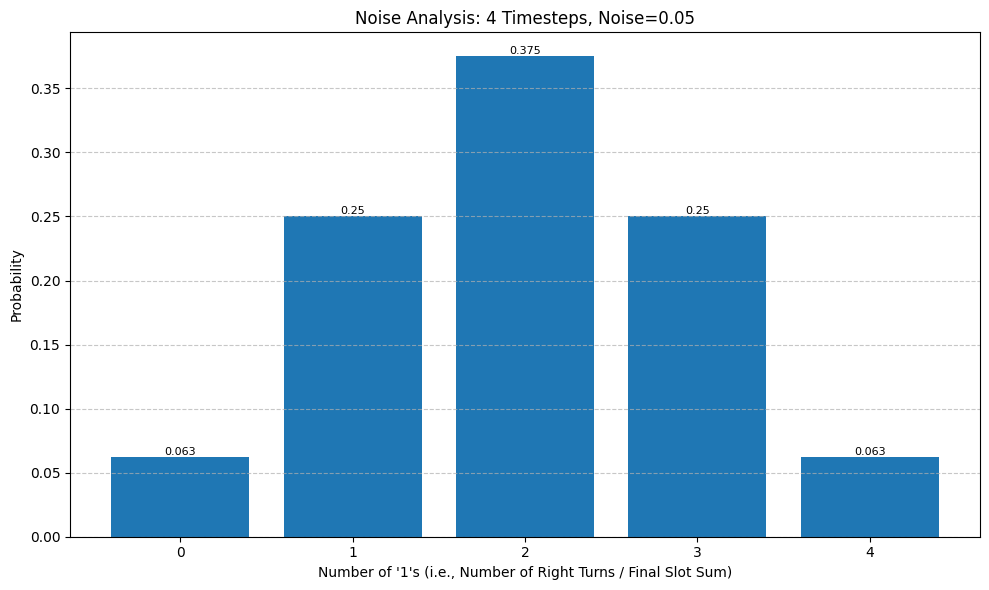

  Noise=0.05:
    Fidelity: 1.0000
    Hellinger Distance: 0.0000
    KL Divergence: 0.0000
    Total Variation Distance: 0.0000


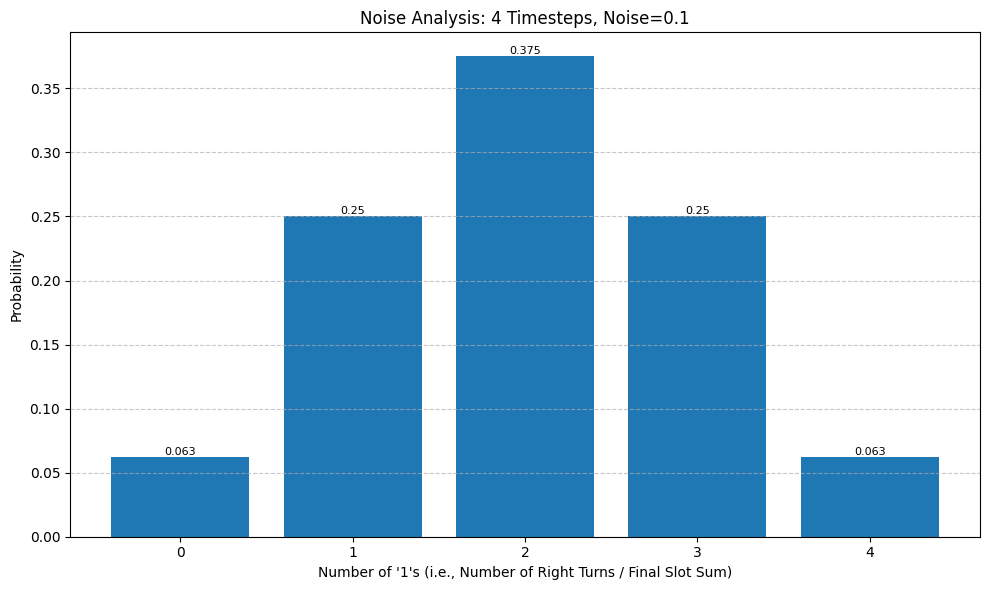

  Noise=0.1:
    Fidelity: 1.0000
    Hellinger Distance: 0.0000
    KL Divergence: -0.0000
    Total Variation Distance: 0.0000

Finding maximum feasible timesteps under noise (noise_prob=0.02) with distances:


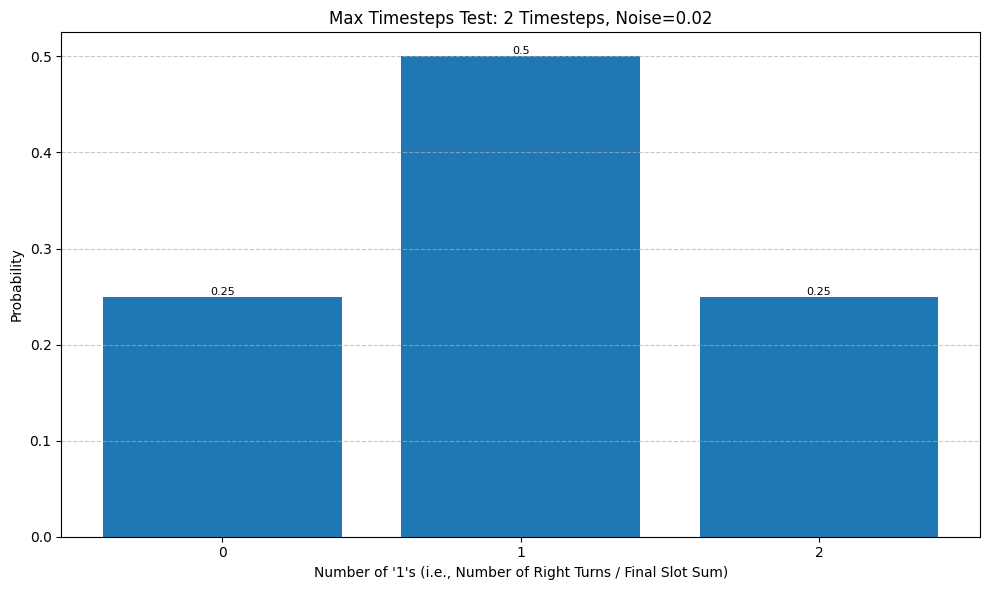

  Timesteps=2, Noise=0.02:
    Fidelity: 1.0000
    Hellinger Distance: 0.0000
    KL Divergence: 0.0000
    Total Variation Distance: 0.0000


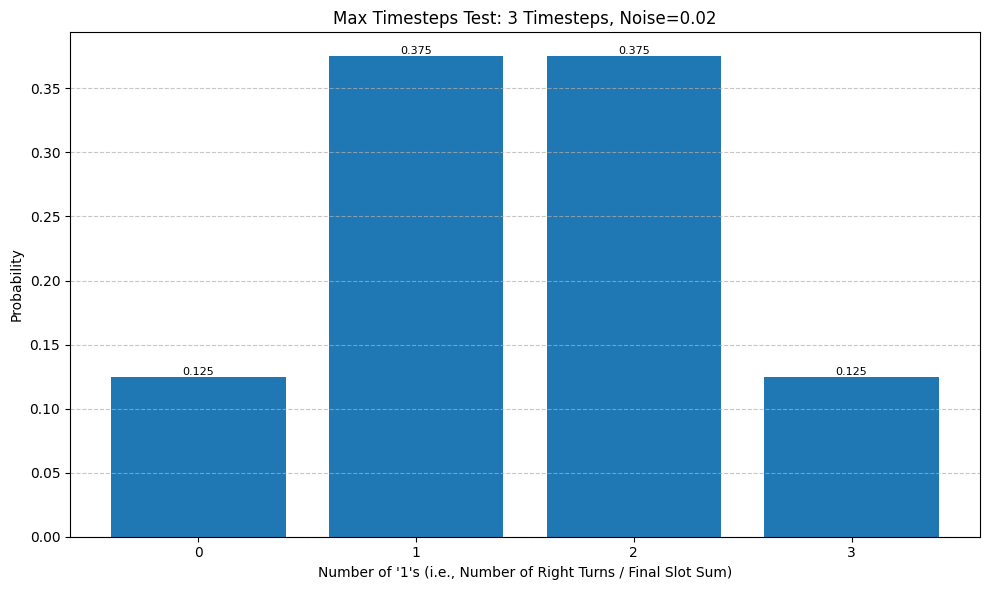

  Timesteps=3, Noise=0.02:
    Fidelity: 1.0000
    Hellinger Distance: 0.0000
    KL Divergence: -0.0000
    Total Variation Distance: 0.0000


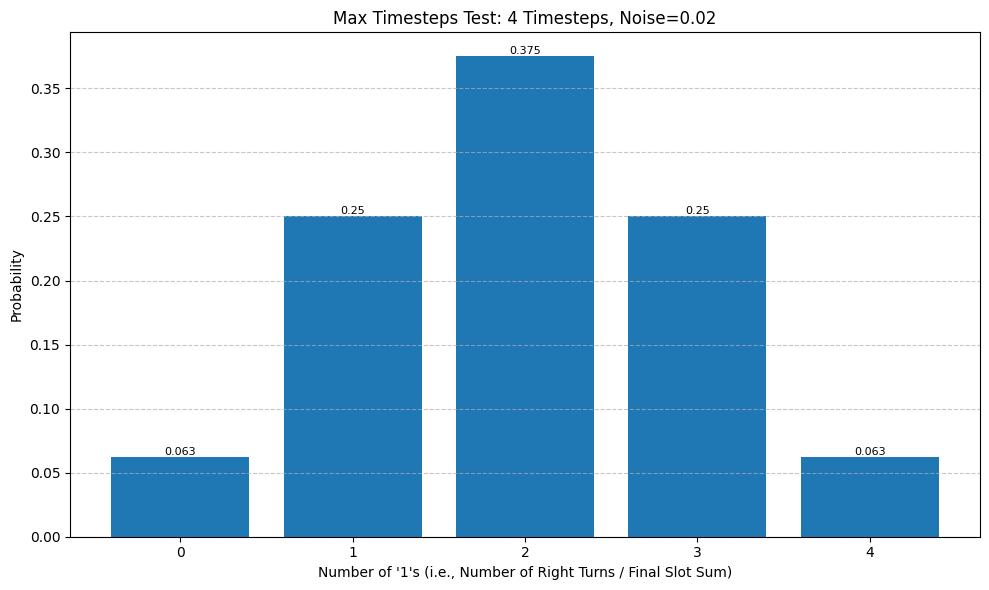

  Timesteps=4, Noise=0.02:
    Fidelity: 1.0000
    Hellinger Distance: 0.0000
    KL Divergence: 0.0000
    Total Variation Distance: 0.0000


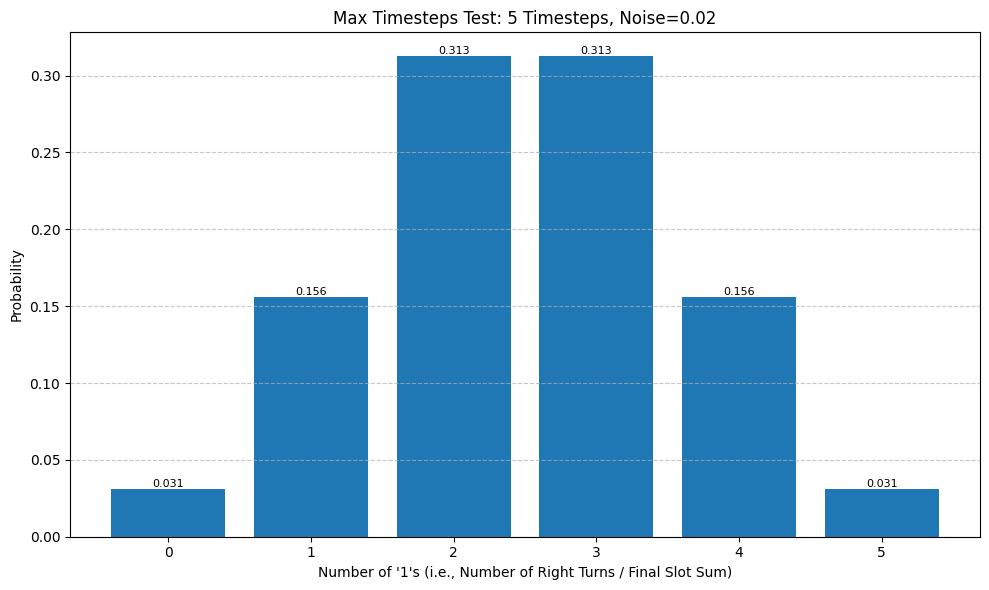

  Timesteps=5, Noise=0.02:
    Fidelity: 1.0000
    Hellinger Distance: 0.0000
    KL Divergence: -0.0000
    Total Variation Distance: 0.0000


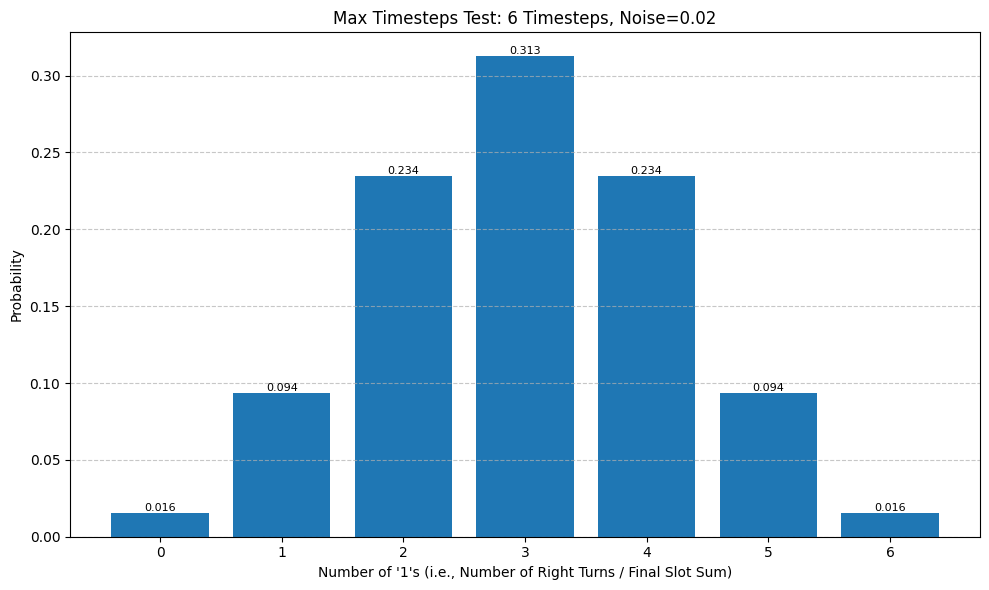

  Timesteps=6, Noise=0.02:
    Fidelity: 1.0000
    Hellinger Distance: 0.0000
    KL Divergence: 0.0000
    Total Variation Distance: 0.0000


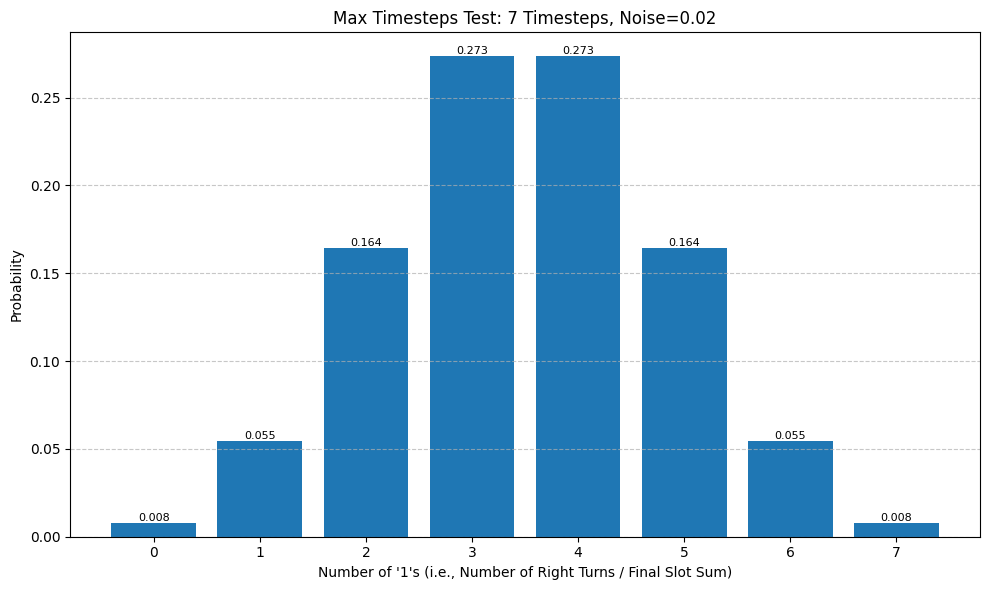

  Timesteps=7, Noise=0.02:
    Fidelity: 1.0000
    Hellinger Distance: 0.0000
    KL Divergence: 0.0000
    Total Variation Distance: 0.0000


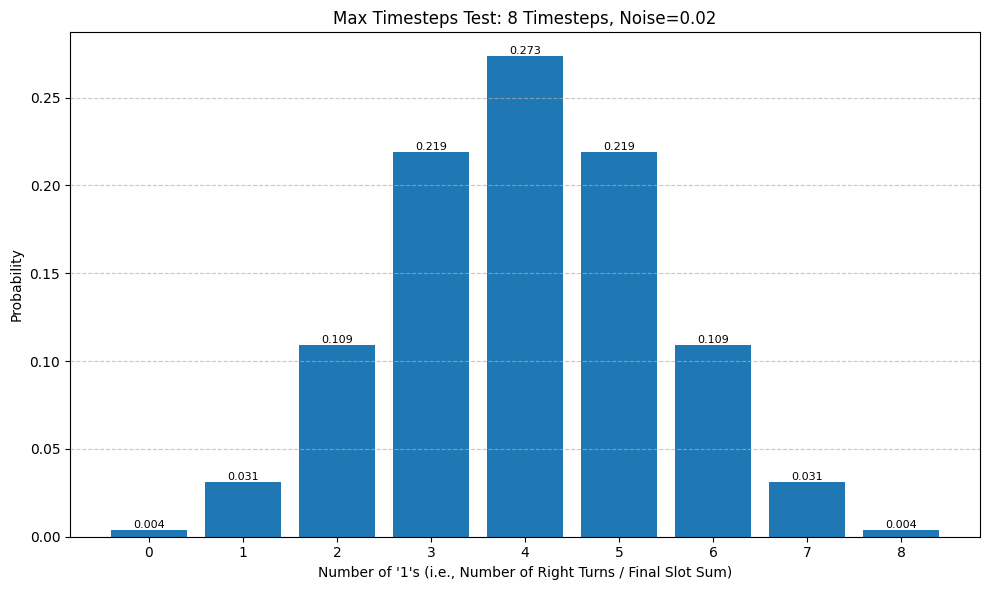

  Timesteps=8, Noise=0.02:
    Fidelity: 1.0000
    Hellinger Distance: 0.0000
    KL Divergence: -0.0000
    Total Variation Distance: 0.0000

Maximum feasible timesteps under noise_prob=0.02: 8

Noise analysis completed. The results show:
- How different noise levels distort the binomial distribution
- The maximum circuit depth (timesteps) that can be run before noise dominates
- The practical limits of the quantum Plinko simulation under noise


In [ ]:
print("\n--- Challenge 3: Noise Model Analysis (Plinko) ---")

def analyze_noise_impact(max_timesteps_to_test=8, max_noise_prob=0.1):
    print("\nTesting different noise levels with 4 timesteps (Unbiased Plinko):")
    noise_levels = [0.0, 0.01, 0.02, 0.05, 0.1]
    timesteps_for_noise_test = 4

    target_probs_noiseless = quantum_plinko_circuit(timesteps_for_noise_test,
                                                    bias_angle_rad=np.pi/2,
                                                    noise_prob_per_gate=0.0)
    num_outcomes = len(target_probs_noiseless)
    target_binomial_probs = np.zeros(timesteps_for_noise_test + 1)
    for i in range(num_outcomes):
        num_ones = bin(i).count('1')
        target_binomial_probs[num_ones] += target_probs_noiseless[i]

    print(f"Noiseless Target Binomial Probs ({timesteps_for_noise_test} timesteps): {target_binomial_probs}")


    for noise_prob in noise_levels:
        probs_raw = quantum_plinko_circuit(timesteps_for_noise_test,
                                           bias_angle_rad=np.pi/2,
                                           noise_prob_per_gate=noise_prob)
        plot_binomial_distribution(probs_raw, timesteps_for_noise_test,
                                   f"Noise Analysis: {timesteps_for_noise_test} Timesteps, Noise={noise_prob}")

        num_outcomes_noisy = len(probs_raw)
        noisy_binomial_probs = np.zeros(timesteps_for_noise_test + 1)
        for i in range(num_outcomes_noisy):
            num_ones = bin(i).count('1')
            noisy_binomial_probs[num_ones] += probs_raw[i]

        fidelity = calculate_fidelity(target_binomial_probs, noisy_binomial_probs)
        hellinger = calculate_hellinger_distance(target_binomial_probs, noisy_binomial_probs)
        kl_div = calculate_kullback_leibler_divergence(noisy_binomial_probs, target_binomial_probs)
        tvd = calculate_total_variation_distance(target_binomial_probs, noisy_binomial_probs)

        print(f"  Noise={noise_prob}:")
        print(f"    Fidelity: {fidelity:.4f}")
        print(f"    Hellinger Distance: {hellinger:.4f}")
        print(f"    KL Divergence: {kl_div:.4f}")
        print(f"    Total Variation Distance: {tvd:.4f}")


    print("\nFinding maximum feasible timesteps under noise (noise_prob=0.02) with distances:")
    noise_prob_max_test = 0.02
    current_timesteps = 2

    while current_timesteps <= max_timesteps_to_test:
        try:
            target_probs_noiseless_current = quantum_plinko_circuit(current_timesteps,
                                                                    bias_angle_rad=np.pi/2,
                                                                    noise_prob_per_gate=0.0)
            num_outcomes_target_current = len(target_probs_noiseless_current)
            target_binomial_probs_current = np.zeros(current_timesteps + 1)
            for i in range(num_outcomes_target_current):
                num_ones = bin(i).count('1')
                target_binomial_probs_current[num_ones] += target_probs_noiseless_current[i]

            probs_raw_noisy_current = quantum_plinko_circuit(current_timesteps,
                                                             bias_angle_rad=np.pi/2,
                                                             noise_prob_per_gate=noise_prob_max_test)
            num_outcomes_noisy_current = len(probs_raw_noisy_current)
            noisy_binomial_probs_current = np.zeros(current_timesteps + 1)
            for i in range(num_outcomes_noisy_current):
                num_ones = bin(i).count('1')
                noisy_binomial_probs_current[num_ones] += probs_raw_noisy_current[i]


            plot_binomial_distribution(probs_raw_noisy_current, current_timesteps,
                                       f"Max Timesteps Test: {current_timesteps} Timesteps, Noise={noise_prob_max_test}")

            fidelity = calculate_fidelity(target_binomial_probs_current, noisy_binomial_probs_current)
            hellinger = calculate_hellinger_distance(target_binomial_probs_current, noisy_binomial_probs_current)
            kl_div = calculate_kullback_leibler_divergence(noisy_binomial_probs_current, target_binomial_probs_current)
            tvd = calculate_total_variation_distance(target_binomial_probs_current, noisy_binomial_probs_current)

            print(f"  Timesteps={current_timesteps}, Noise={noise_prob_max_test}:")
            print(f"    Fidelity: {fidelity:.4f}")
            print(f"    Hellinger Distance: {hellinger:.4f}")
            print(f"    KL Divergence: {kl_div:.4f}")
            print(f"    Total Variation Distance: {tvd:.4f}")

            current_timesteps += 1
        except Exception as e:
            print(f"Failed at {current_timesteps} timesteps with noise {noise_prob_max_test}: {str(e)}")
            break

    print(f"\nMaximum feasible timesteps under noise_prob={noise_prob_max_test}: {current_timesteps-1}")

analyze_noise_impact()

print("\nNoise analysis completed. The results show:")
print("- How different noise levels distort the binomial distribution")
print("- The maximum circuit depth (timesteps) that can be run before noise dominates")
print("- The practical limits of the quantum Plinko simulation under noise")

# Main Noise Analysis Function

In [ ]:
# Plotting Functions
def plot_distribution(probabilities, title, x_labels=None, label_rotation=45):
    """Plots a general probability distribution."""
    num_outcomes = len(probabilities)
    outcomes = np.arange(num_outcomes)

    plt.figure(figsize=(10, 6))
    plt.bar(outcomes, probabilities)
    plt.title(title)
    plt.xlabel("Output State")
    plt.ylabel("Probability")

    if x_labels:
        plt.xticks(outcomes, x_labels, rotation=label_rotation, ha='right')
    else:
        # Default labels based on number of outcomes
        num_output_bits = int(np.ceil(np.log2(num_outcomes)))
        if num_outcomes <= 16:
            plt.xticks(outcomes, [f"{i:0{num_output_bits}b}" for i in outcomes], rotation=label_rotation, ha='right')
        elif num_outcomes <= 64:
            plt.xticks(outcomes[::2], [f"{i:0{num_output_bits}b}" for i in outcomes[::2]], rotation=label_rotation, ha='right')
        else:
            plt.xticks(outcomes[::4], [f"{i:0{num_output_bits}b}" for i in outcomes[::4]], rotation=label_rotation, ha='right')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_binomial_distribution(probabilities, num_timesteps, title, ideal_probs=None):
    """
    Plots a binomial-like distribution by summing probabilities of states
    with the same number of '1's.
    """
    if num_timesteps == 0:
        print("Cannot plot binomial distribution for 0 timesteps.")
        return

    # Aggregate probabilities by number of ones
    sum_probabilities = np.zeros(num_timesteps + 1)
    for i in range(len(probabilities)):
        num_ones = bin(i).count('1')
        if num_ones < len(sum_probabilities):
            sum_probabilities[num_ones] += probabilities[i]

    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    x = np.arange(num_timesteps + 1)
    bars_measured = plt.bar(x - bar_width/2, sum_probabilities, bar_width, label="Measured")

    if ideal_probs is not None:
        bars_ideal = plt.bar(x + bar_width/2, ideal_probs, bar_width, label="Ideal")

    plt.title(title)
    plt.xlabel("Number of '1's (i.e., Number of Right Turns)")
    plt.ylabel("Probability")
    plt.xticks(x)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return sum_probabilities

In [ ]:
#  Quantum Circuits
def quantum_plinko_circuit_factory(num_timesteps, bias_angle_rad, noise_channel=None, noise_prob=0.0):
    """
    Returns a QNode for the quantum plinko circuit with a given noise channel.
    This factory pattern allows for easy injection of different noise models.
    """
    total_qubits = 1 + num_timesteps
    dev = qml.device("default.mixed", wires=total_qubits, shots=1000)

    @qml.qnode(dev)
    def circuit():
        decision_wire = 0
        output_wires = list(range(1, total_qubits))

        qml.RY(bias_angle_rad, wires=decision_wire)
        if noise_prob > 0 and noise_channel:
            noise_channel(noise_prob, wires=decision_wire)

        for t in range(num_timesteps):
            qml.CNOT(wires=[decision_wire, output_wires[t]])
            if noise_prob > 0 and noise_channel:
                noise_channel(noise_prob, wires=decision_wire)
                noise_channel(noise_prob, wires=output_wires[t])
            qml.RY(bias_angle_rad, wires=decision_wire)
            if noise_prob > 0 and noise_channel:
                noise_channel(noise_prob, wires=decision_wire)

        return qml.probs(output_wires)

    return circuit

def hadamard_quantum_walk_circuit_factory(num_steps, noise_channel=None, noise_prob=0.0):
    """
    Returns a QNode for the Hadamard Quantum Walk circuit with noise.
    The position register is represented by 'num_steps' qubits.
    """
    coin_wire = 0
    position_wires = list(range(1, num_steps + 1))
    total_qubits = 1 + num_steps
    dev = qml.device("default.mixed", wires=total_qubits, shots=1000)

    @qml.qnode(dev)
    def circuit():
        qml.Hadamard(wires=coin_wire)
        if noise_prob > 0 and noise_channel:
            noise_channel(noise_prob, wires=coin_wire)

        for s in range(num_steps):
            qml.Hadamard(wires=coin_wire)
            if noise_prob > 0 and noise_channel:
                noise_channel(noise_prob, wires=coin_wire)

            qml.CNOT(wires=[coin_wire, position_wires[s]])
            if noise_prob > 0 and noise_channel:
                noise_channel(noise_prob, wires=coin_wire)
                noise_channel(noise_prob, wires=position_wires[s])

            if noise_prob > 0 and noise_channel:
                noise_channel(noise_prob, wires=coin_wire)
                noise_channel(noise_prob, wires=position_wires[s])

        return qml.probs(position_wires)

    return circuit

def exponential_state_preparation_factory(num_qubits, decay_rate, noise_channel=None, noise_prob=0.0):
    """
    Returns a QNode for an exponential state preparation circuit with noise.
    """
    dev = qml.device("default.mixed", wires=num_qubits, shots=1000)

    # Calculate the target probability distribution
    x_values = np.arange(2**num_qubits)
    prob_dist = np.exp(-decay_rate * x_values)
    prob_dist /= np.sum(prob_dist)

    @qml.qnode(dev)
    def circuit():
        qml.MottonenStatePreparation(np.sqrt(prob_dist), wires=range(num_qubits))

        if noise_prob > 0 and noise_channel:
            for w in range(num_qubits):
                noise_channel(noise_prob, wires=w)

        return qml.probs(wires=range(num_qubits))

    return circuit, prob_dist


In [ ]:
# Distance Metric Functions
def calculate_fidelity(prob_dist1, prob_dist2):
    """Calculates the fidelity between two probability distributions."""
    if len(prob_dist1) != len(prob_dist2):
        raise ValueError("Distributions must have the same number of outcomes.")
    prob_dist1 = np.maximum(prob_dist1, 0)
    prob_dist2 = np.maximum(prob_dist2, 0)
    fidelity = (np.sum(np.sqrt(prob_dist1 * prob_dist2)))**2
    return fidelity

def calculate_hellinger_distance(prob_dist1, prob_dist2):
    """Calculates the Hellinger distance between two probability distributions."""
    if len(prob_dist1) != len(prob_dist2):
        raise ValueError("Distributions must have the same number of outcomes.")
    prob_dist1 = np.maximum(prob_dist1, 0)
    prob_dist2 = np.maximum(prob_dist2, 0)
    hellinger_dist = np.sqrt(np.sum((np.sqrt(prob_dist1) - np.sqrt(prob_dist2))**2)) / np.sqrt(2)
    return hellinger_dist

def calculate_kullback_leibler_divergence(prob_dist_p, prob_dist_q):
    """Calculates the KL divergence between two probability distributions."""
    if len(prob_dist_p) != len(prob_dist_q):
        raise ValueError("Distributions must have the same number of outcomes.")
    epsilon = 1e-10
    prob_dist_p = np.maximum(prob_dist_p, epsilon)
    prob_dist_q = np.maximum(prob_dist_q, epsilon)
    kl_div = entropy(prob_dist_p, qk=prob_dist_q)
    return kl_div

def calculate_total_variation_distance(prob_dist1, prob_dist2):
    """Calculates the total variation distance between two distributions."""
    if len(prob_dist1) != len(prob_dist2):
        raise ValueError("Distributions must have the same number of outcomes.")
    tvd = 0.5 * np.sum(np.abs(prob_dist1 - prob_dist2))
    return tvd

In [ ]:
# Generalized Noise Analysis Function
def run_noise_analysis(circuit_factory, ideal_dist_func, circuit_params, plot_func, title_prefix, binning_required=False, ideal_dist_is_tuple=False):
    """
    Runs a noise analysis for a given circuit factory and plots the results.

    Args:
        circuit_factory (callable): A function that returns a QNode for the circuit.
        ideal_dist_func (callable): A function to get the ideal noiseless distribution.
        circuit_params (dict): A dictionary of parameters for the circuit factory.
        plot_func (callable): The plotting function to use.
        title_prefix (str): A string prefix for the plot titles.
        binning_required (bool): Whether the raw probabilities need to be binned (e.g., for Plinko).
        ideal_dist_is_tuple (bool): If the ideal distribution function returns a tuple.
    """

    # Define the noise types and their parameters
    noise_models = {
        "No Noise": (None, 0.0),
        "Depolarizing": (qml.DepolarizingChannel, 0.05),
        "Amplitude Damping": (qml.AmplitudeDamping, 0.05),
        "Phase Damping": (qml.PhaseDamping, 0.05),
        "Bit Flip": (qml.BitFlip, 0.05),
        "Phase Flip": (qml.PhaseFlip, 0.05),
    }

    # Get the ideal noiseless distribution
    if ideal_dist_is_tuple:
        _, ideal_dist_raw = ideal_dist_func(**circuit_params, noise_channel=None, noise_prob=0.0)
    else:
        ideal_dist_raw = ideal_dist_func(**circuit_params, noise_channel=None, noise_prob=0.0)

    if binning_required:
        # Bin the ideal distribution for comparison
        ideal_dist = np.zeros(circuit_params["num_timesteps"] + 1)
        for i in range(len(ideal_dist_raw)):
            num_ones = bin(i).count('1')
            if num_ones < len(ideal_dist):
                ideal_dist[num_ones] += ideal_dist_raw[i]
    else:
        ideal_dist = ideal_dist_raw


    results = {
        "noise_type": [], "fidelity": [], "hellinger": [], "kl_div": [], "tvd": []
    }

    for name, (noise_channel, noise_prob) in noise_models.items():
        print(f"Analyzing {title_prefix} with noise: {name}")

        # Correctly handle the tuple return for the exponential circuit factory
        factory_output = circuit_factory(**circuit_params, noise_channel=noise_channel, noise_prob=noise_prob)
        if isinstance(factory_output, tuple):
            circuit, _ = factory_output
        else:
            circuit = factory_output

        measured_probs_raw = circuit()

        if binning_required:
            measured_probs = np.zeros(circuit_params["num_timesteps"] + 1)
            for i in range(len(measured_probs_raw)):
                num_ones = bin(i).count('1')
                if num_ones < len(measured_probs):
                    measured_probs[num_ones] += measured_probs_raw[i]

            # Plot the binned distribution
            plot_func(measured_probs_raw, circuit_params["num_timesteps"], f"{title_prefix} with {name} Noise", ideal_dist)
        else:
            # For non-binned circuits like exponential, plot both ideal and noisy
            if 'num_qubits' in circuit_params:
                # Use num_qubits for exponential distribution
                x_labels = [f"{i:0{circuit_params['num_qubits']}b}" for i in range(len(measured_probs_raw))]
            elif 'num_steps' in circuit_params:
                # Use num_steps for quantum walk
                x_labels = [f"{i:0{circuit_params['num_steps']}b}" for i in range(len(measured_probs_raw))]
            else:
                x_labels = None

            plot_distribution(measured_probs_raw, f"{title_prefix} with {name} Noise", x_labels=x_labels)
            measured_probs = measured_probs_raw

        fidelity_val = calculate_fidelity(ideal_dist, measured_probs)
        hellinger_val = calculate_hellinger_distance(ideal_dist, measured_probs)
        kl_div_val = calculate_kullback_leibler_divergence(measured_probs, ideal_dist)
        tvd_val = calculate_total_variation_distance(ideal_dist, measured_probs)

        results["noise_type"].append(name)
        results["fidelity"].append(fidelity_val)
        results["hellinger"].append(hellinger_val)
        results["kl_div"].append(kl_div_val)
        results["tvd"].append(tvd_val)

        print(f"  Fidelity: {fidelity_val:.4f}")
        print(f"  Hellinger Distance: {hellinger_val:.4f}")
        print(f"  KL Divergence: {kl_div_val:.4f}")
        print(f"  Total Variation Distance: {tvd_val:.4f}")
        print("-" * 30)

    # Plot summary bar chart for the metrics
    labels = results["noise_type"]
    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - 1.5*width, results["fidelity"], width, label="Fidelity")
    ax.bar(x - 0.5*width, results["kl_div"], width, label="KL Divergence")
    ax.bar(x + 0.5*width, results["hellinger"], width, label="Hellinger Distance")
    ax.bar(x + 1.5*width, results["tvd"], width, label="Total Variation Distance")

    ax.set_ylabel("Metric Value")
    ax.set_title(f"Effect of Different Noise Types on {title_prefix} Distribution")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha="right")
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()


Starting noise analysis for all circuits...

Analyzing Quantum Plinko Circuit

Analyzing Quantum Plinko (Binomial) with noise: No Noise


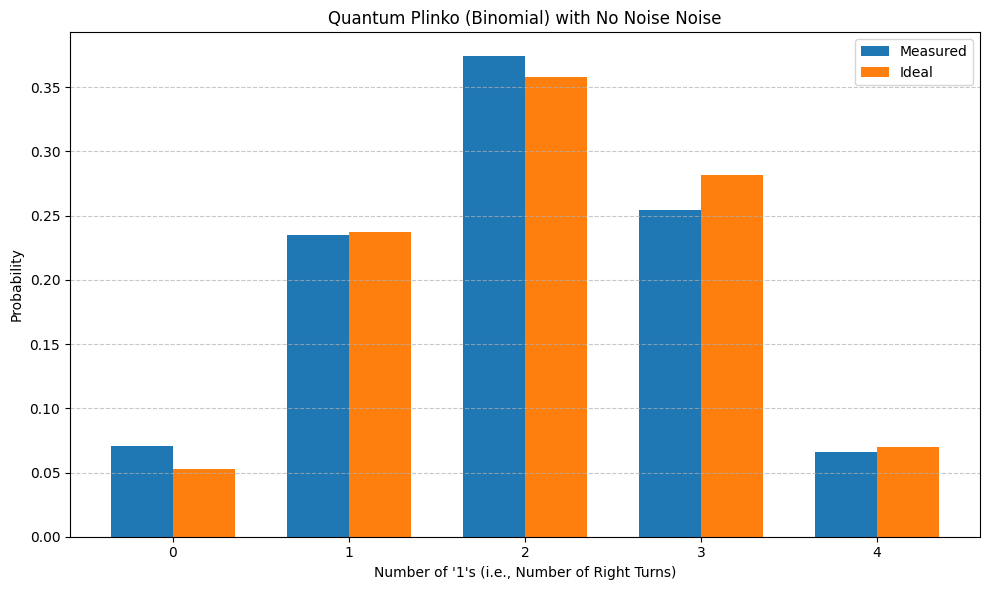

  Fidelity: 0.9977
  Hellinger Distance: 0.0338
  KL Divergence: 0.0047
  Total Variation Distance: 0.0340
------------------------------
Analyzing Quantum Plinko (Binomial) with noise: Depolarizing


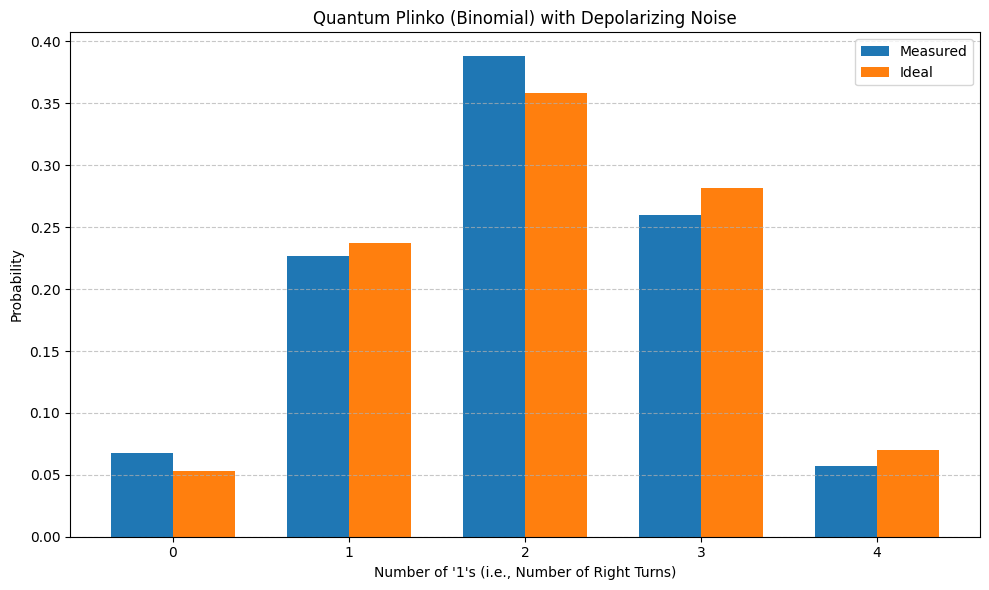

  Fidelity: 0.9972
  Hellinger Distance: 0.0371
  KL Divergence: 0.0056
  Total Variation Distance: 0.0450
------------------------------
Analyzing Quantum Plinko (Binomial) with noise: Amplitude Damping


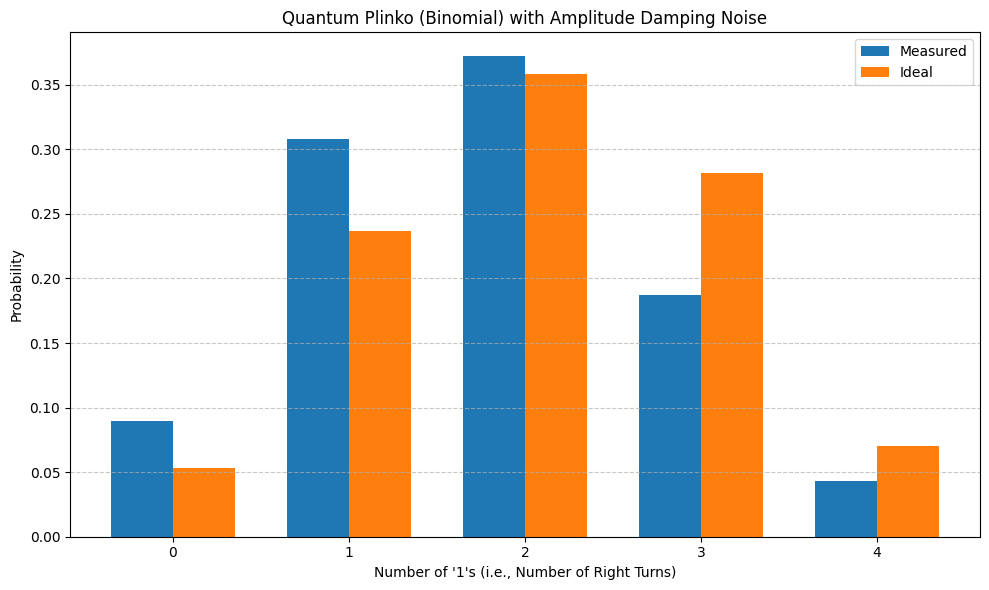

  Fidelity: 0.9775
  Hellinger Distance: 0.1064
  KL Divergence: 0.0449
  Total Variation Distance: 0.1220
------------------------------
Analyzing Quantum Plinko (Binomial) with noise: Phase Damping


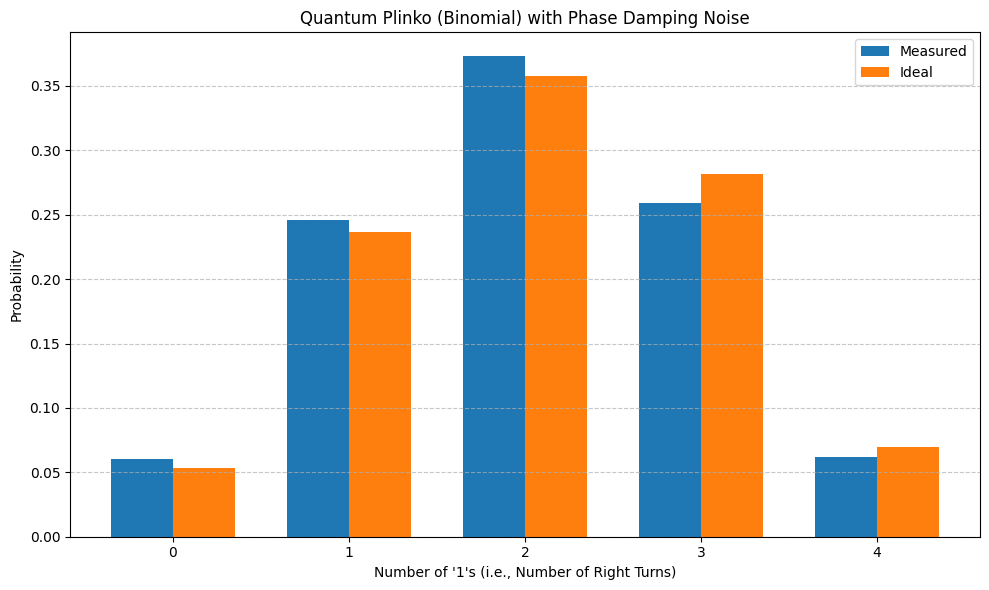

  Fidelity: 0.9988
  Hellinger Distance: 0.0244
  KL Divergence: 0.0024
  Total Variation Distance: 0.0310
------------------------------
Analyzing Quantum Plinko (Binomial) with noise: Bit Flip


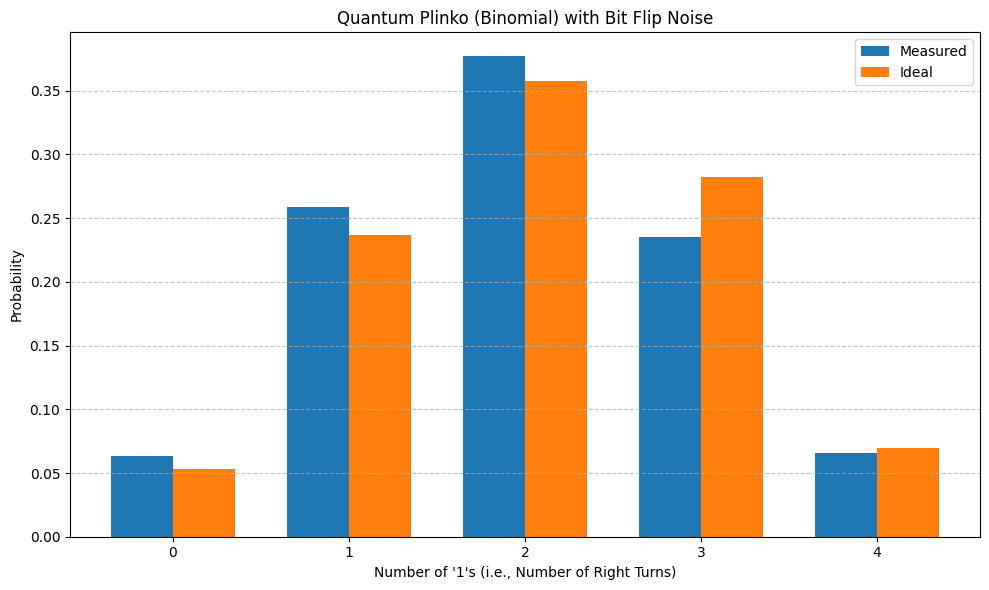

  Fidelity: 0.9966
  Hellinger Distance: 0.0410
  KL Divergence: 0.0066
  Total Variation Distance: 0.0510
------------------------------
Analyzing Quantum Plinko (Binomial) with noise: Phase Flip


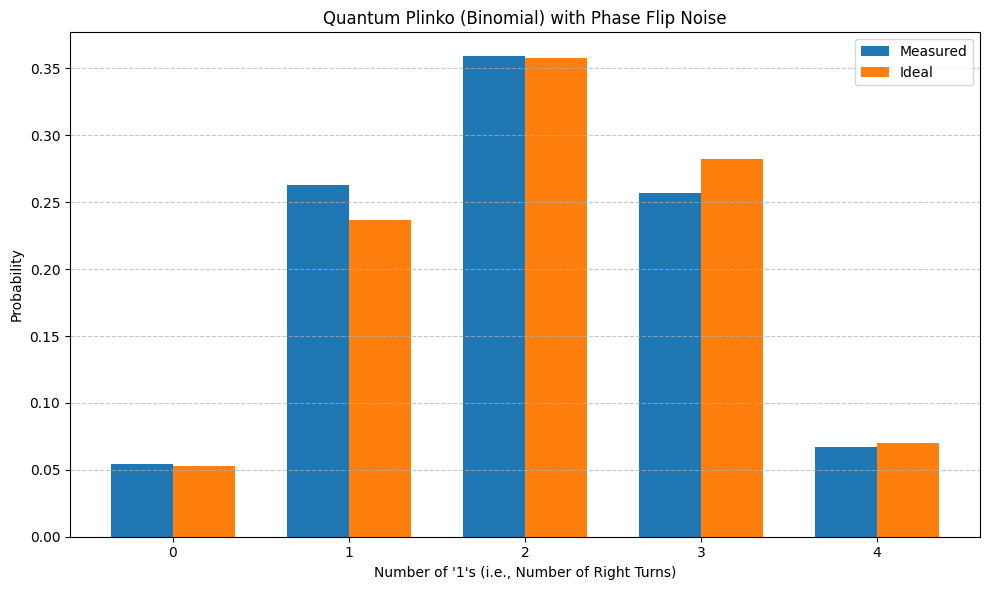

  Fidelity: 0.9987
  Hellinger Distance: 0.0254
  KL Divergence: 0.0026
  Total Variation Distance: 0.0280
------------------------------


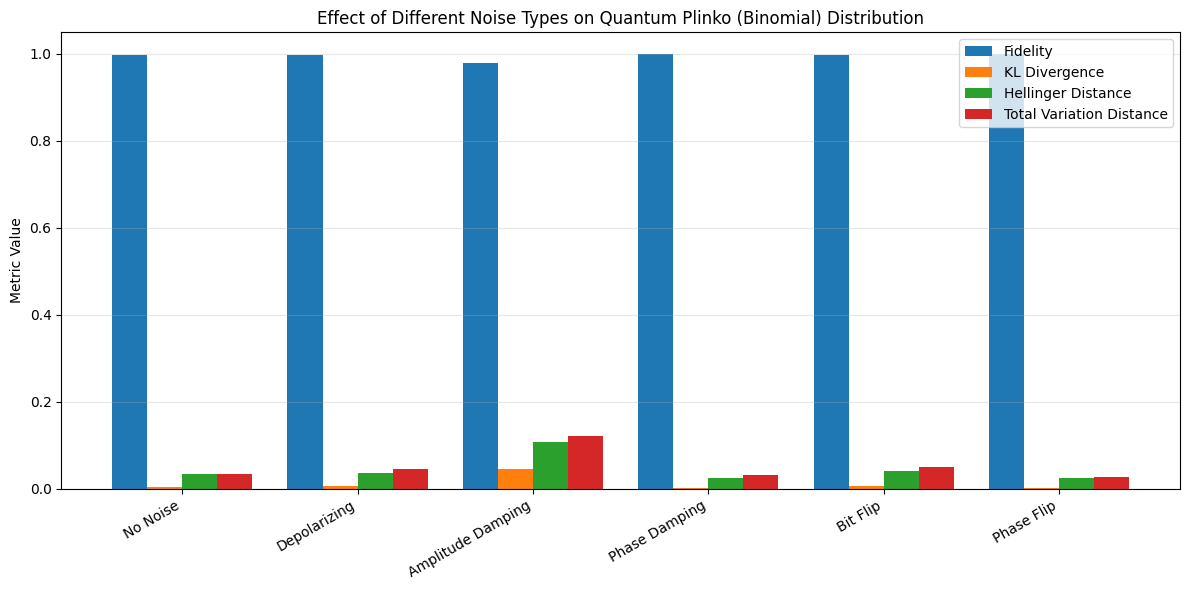


Analyzing Hadamard Quantum Walk Circuit

Analyzing Hadamard Quantum Walk with noise: No Noise


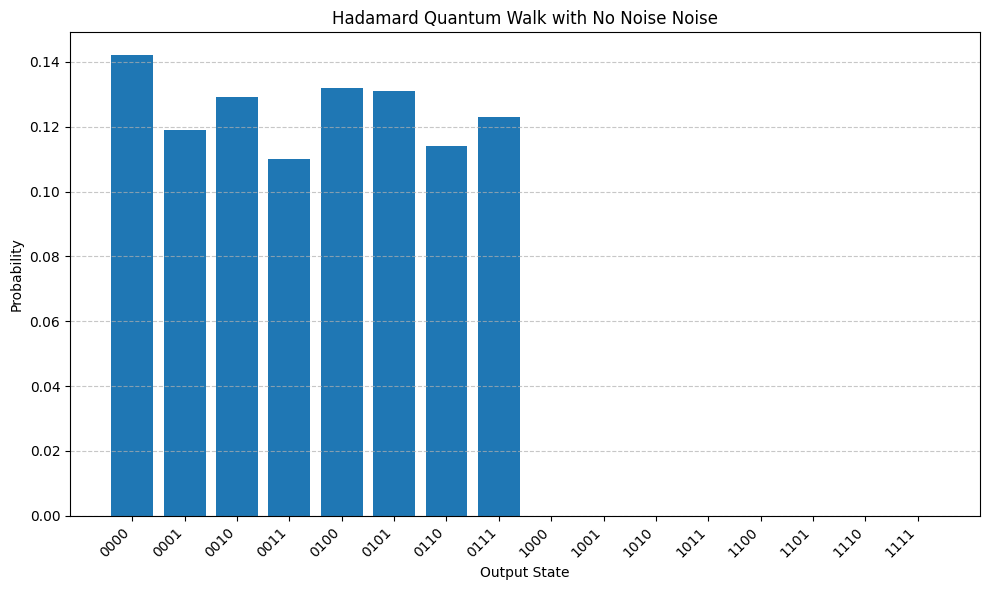

  Fidelity: 0.9953
  Hellinger Distance: 0.0484
  KL Divergence: 0.0093
  Total Variation Distance: 0.0530
------------------------------
Analyzing Hadamard Quantum Walk with noise: Depolarizing


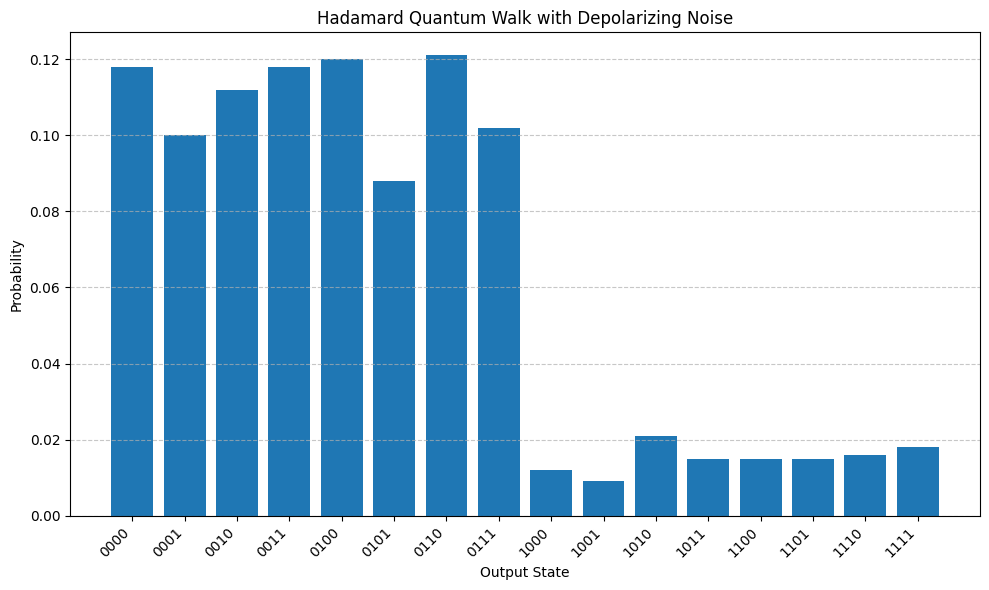

  Fidelity: 0.8753
  Hellinger Distance: 0.2538
  KL Divergence: 2.1761
  Total Variation Distance: 0.1250
------------------------------
Analyzing Hadamard Quantum Walk with noise: Amplitude Damping


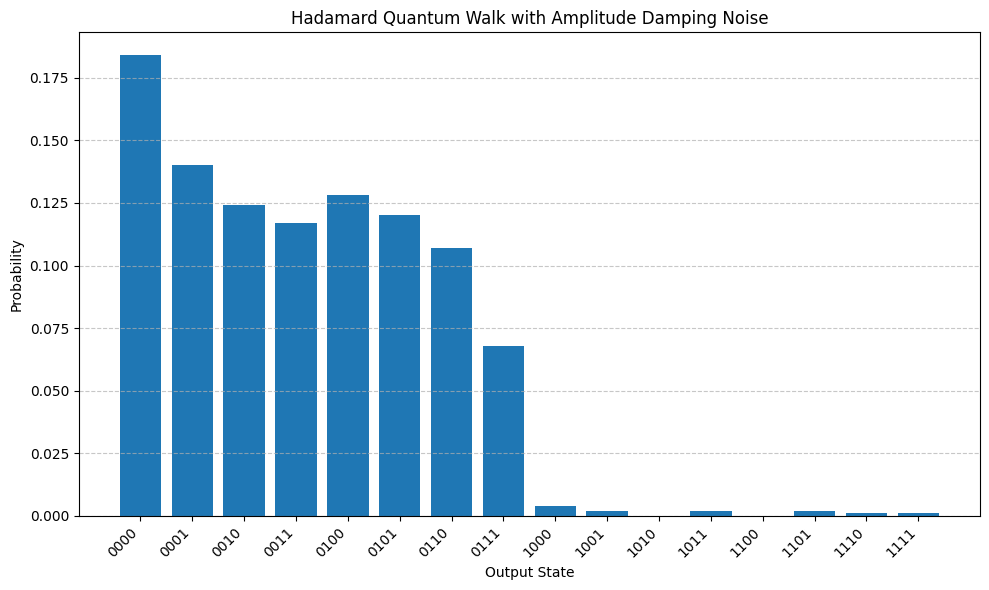

  Fidelity: 0.9701
  Hellinger Distance: 0.1228
  KL Divergence: 0.2272
  Total Variation Distance: 0.0990
------------------------------
Analyzing Hadamard Quantum Walk with noise: Phase Damping


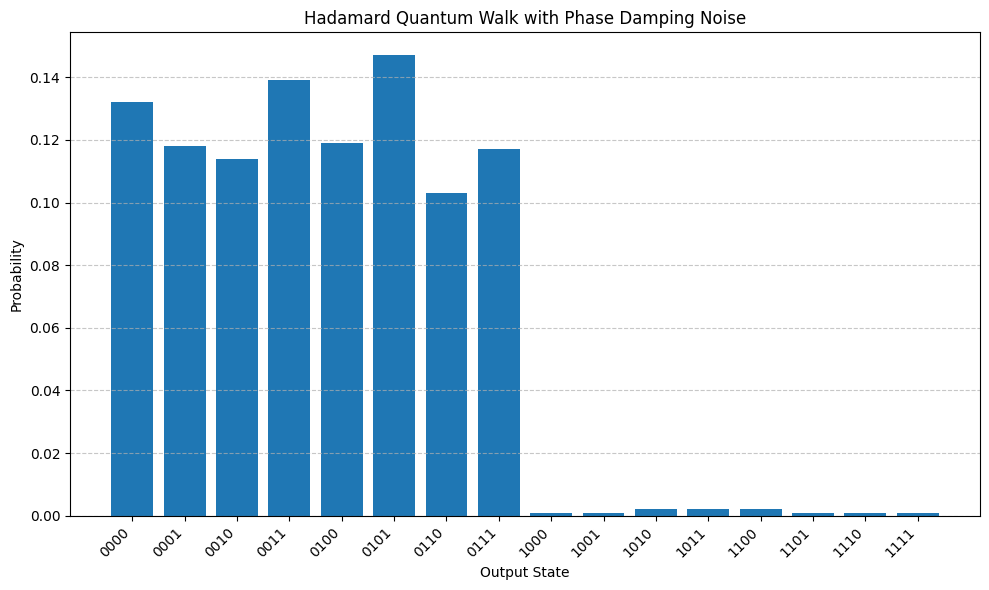

  Fidelity: 0.9860
  Hellinger Distance: 0.0839
  KL Divergence: 0.1766
  Total Variation Distance: 0.0530
------------------------------
Analyzing Hadamard Quantum Walk with noise: Bit Flip


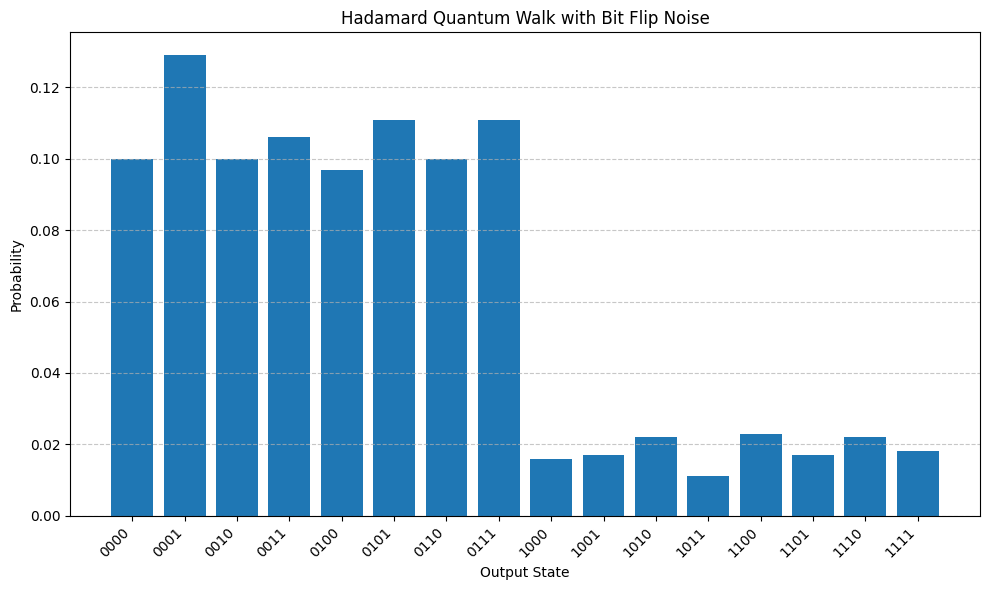

  Fidelity: 0.8524
  Hellinger Distance: 0.2771
  KL Divergence: 2.6489
  Total Variation Distance: 0.1460
------------------------------
Analyzing Hadamard Quantum Walk with noise: Phase Flip


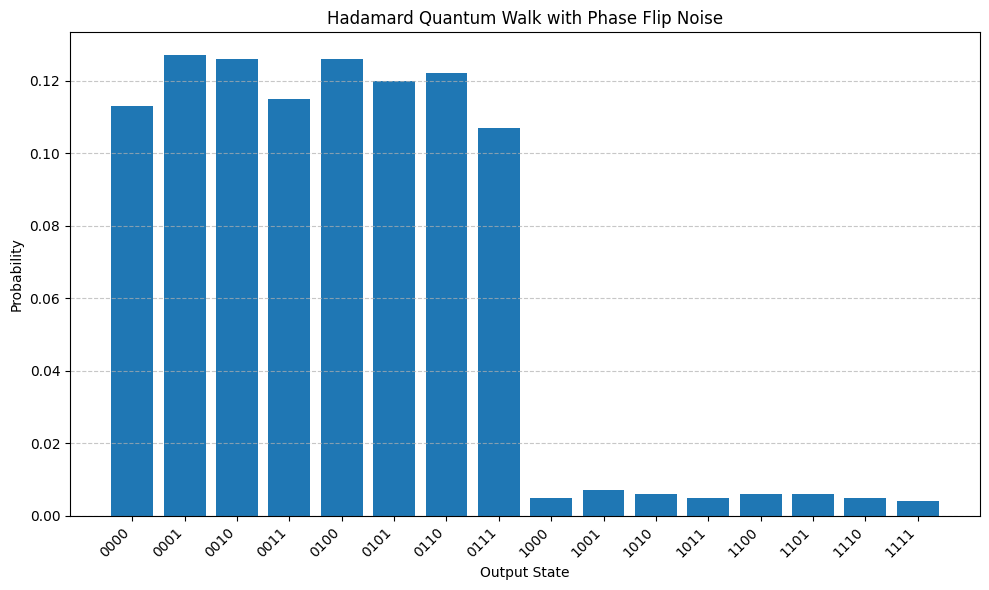

  Fidelity: 0.9540
  Hellinger Distance: 0.1526
  KL Divergence: 0.7458
  Total Variation Distance: 0.0600
------------------------------


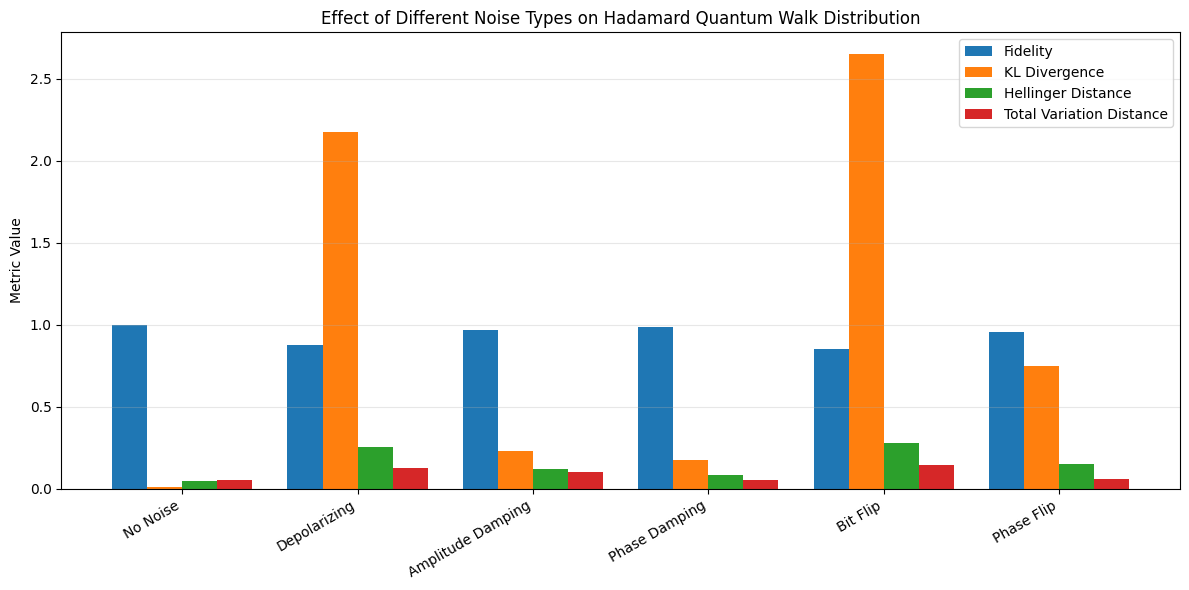


Analyzing Exponential Distribution Circuit

Analyzing Exponential Distribution with noise: No Noise


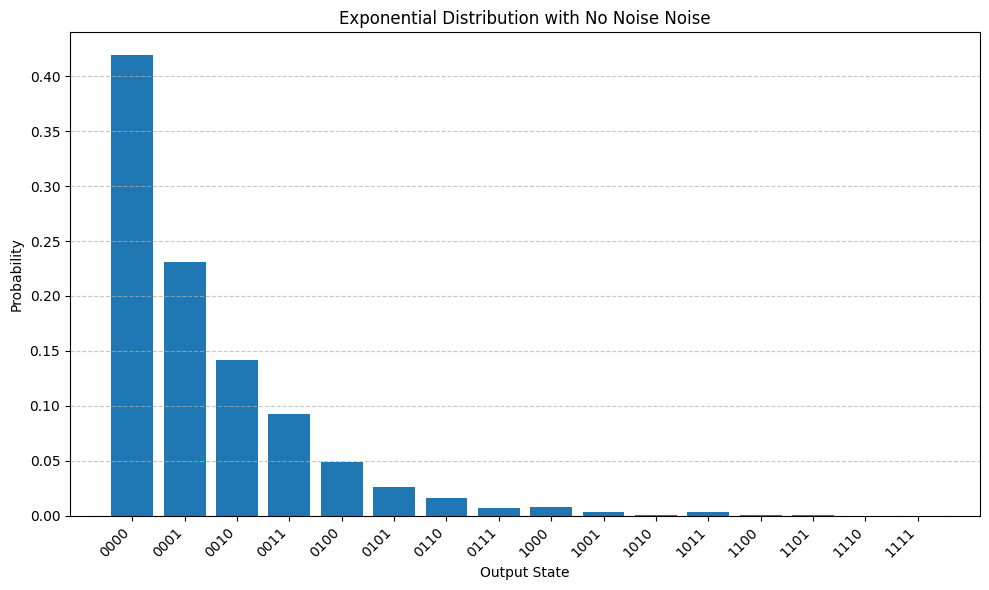

  Fidelity: 0.9968
  Hellinger Distance: 0.0400
  KL Divergence: 0.0056
  Total Variation Distance: 0.0332
------------------------------
Analyzing Exponential Distribution with noise: Depolarizing


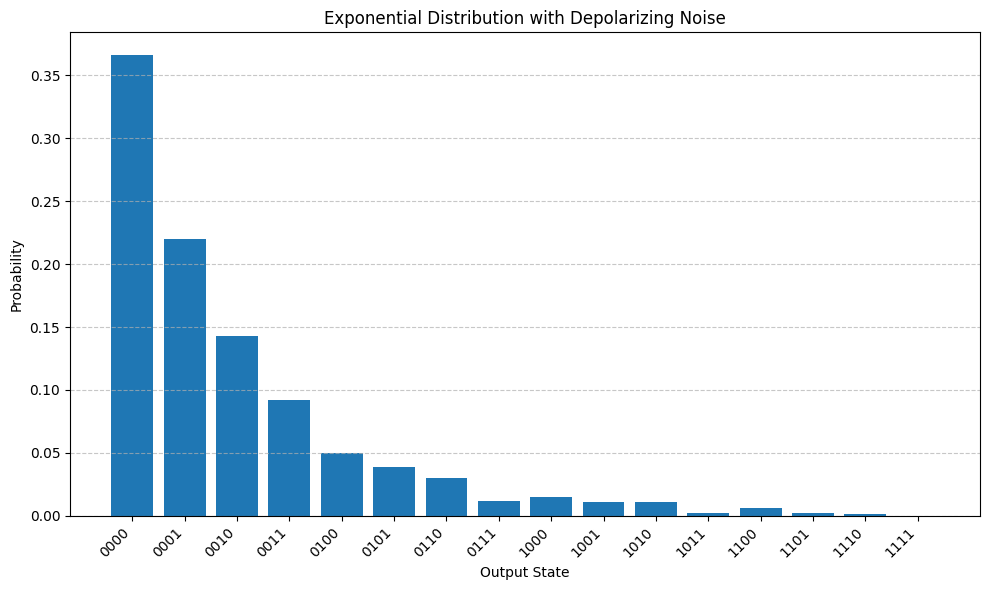

  Fidelity: 0.9889
  Hellinger Distance: 0.0746
  KL Divergence: 0.0265
  Total Variation Distance: 0.0516
------------------------------
Analyzing Exponential Distribution with noise: Amplitude Damping


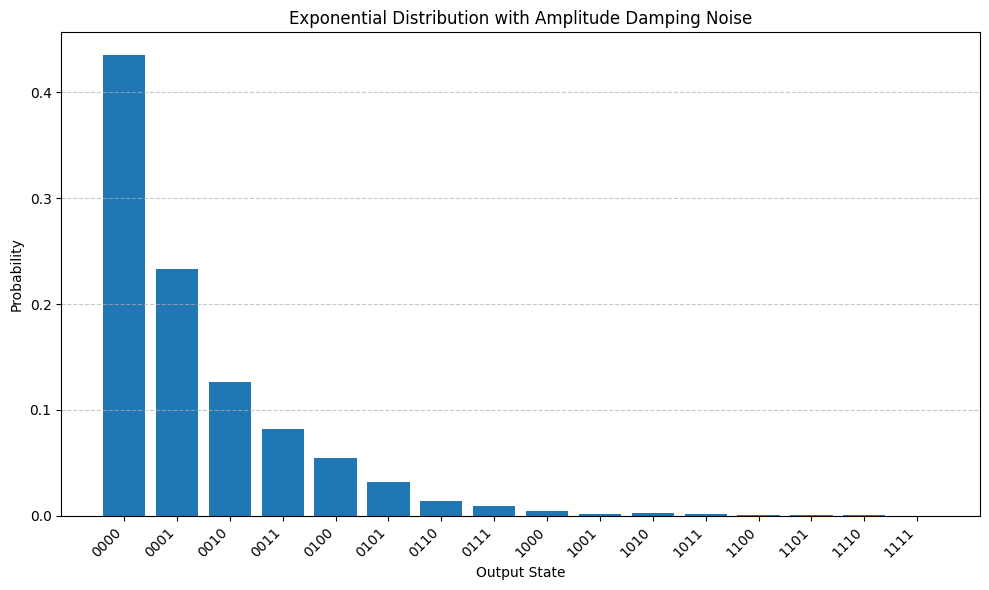

  Fidelity: 0.9961
  Hellinger Distance: 0.0441
  KL Divergence: 0.0074
  Total Variation Distance: 0.0449
------------------------------
Analyzing Exponential Distribution with noise: Phase Damping


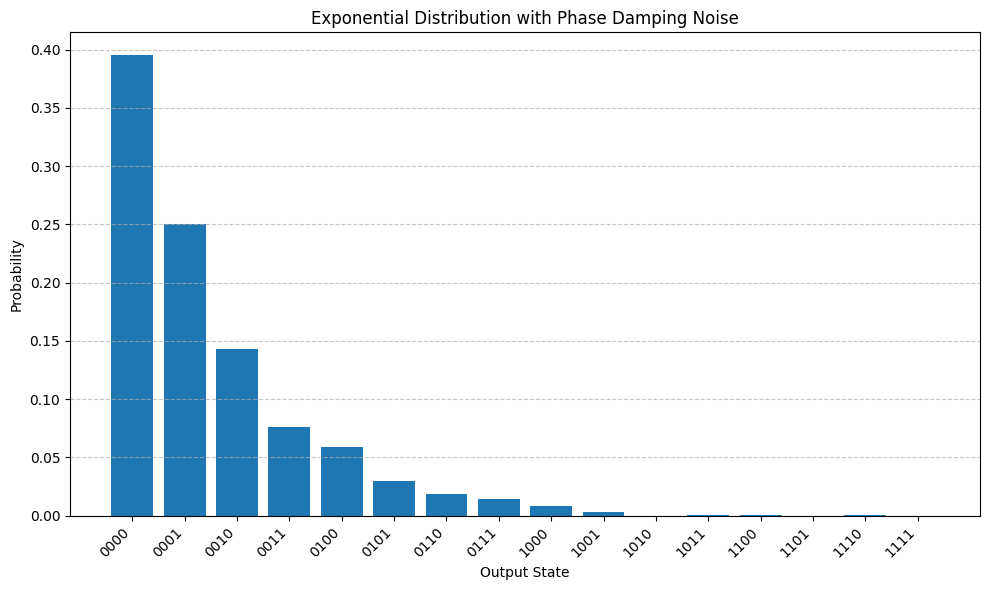

  Fidelity: 0.9953
  Hellinger Distance: 0.0484
  KL Divergence: 0.0059
  Total Variation Distance: 0.0220
------------------------------
Analyzing Exponential Distribution with noise: Bit Flip


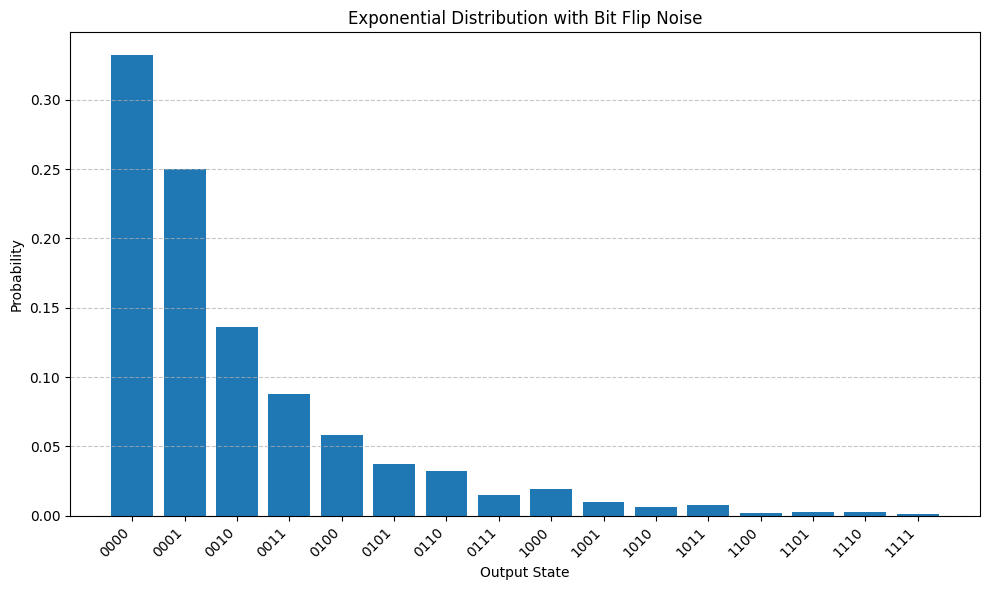

  Fidelity: 0.9855
  Hellinger Distance: 0.0854
  KL Divergence: 0.0344
  Total Variation Distance: 0.0704
------------------------------
Analyzing Exponential Distribution with noise: Phase Flip


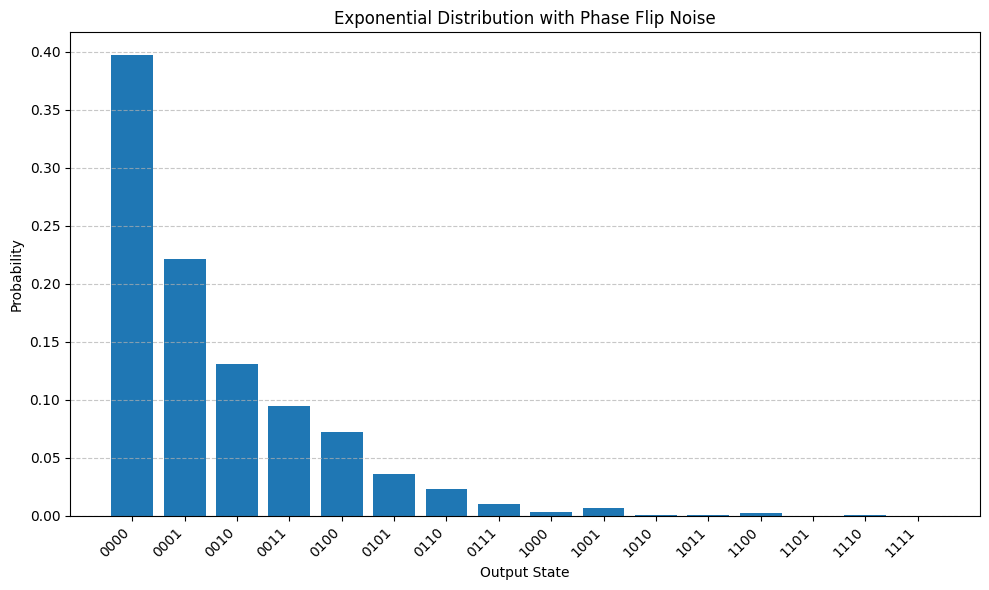

  Fidelity: 0.9946
  Hellinger Distance: 0.0519
  KL Divergence: 0.0099
  Total Variation Distance: 0.0407
------------------------------


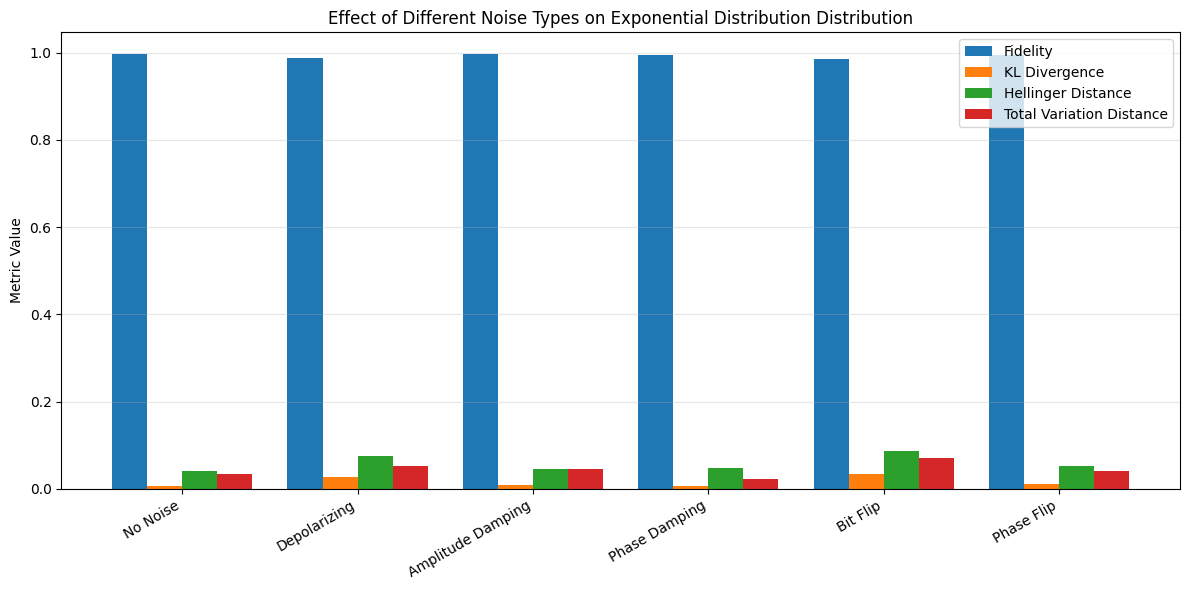

In [ ]:
#  Main Execution
if __name__ == "__main__":
    print("Starting noise analysis for all circuits...")

    # --- Plinko Circuit Analysis ---
    print("\n" + "="*50)
    print("Analyzing Quantum Plinko Circuit")
    print("="*50 + "\n")
    plinko_params = {"num_timesteps": 4, "bias_angle_rad": np.pi/2}

    # Define a function to get the ideal noiseless distribution for plinko
    def ideal_plinko_dist(**kwargs):
        circuit = quantum_plinko_circuit_factory(**kwargs)
        return circuit()

    run_noise_analysis(
        circuit_factory=quantum_plinko_circuit_factory,
        ideal_dist_func=ideal_plinko_dist,
        circuit_params=plinko_params,
        plot_func=plot_binomial_distribution,
        title_prefix="Quantum Plinko (Binomial)",
        binning_required=True
    )

    # --- Hadamard Quantum Walk Analysis ---
    print("\n" + "="*50)
    print("Analyzing Hadamard Quantum Walk Circuit")
    print("="*50 + "\n")
    qw_params = {"num_steps": 4}

    # Define a function to get the ideal noiseless distribution for the walk
    def ideal_qw_dist(**kwargs):
        circuit = hadamard_quantum_walk_circuit_factory(**kwargs)
        return circuit()

    run_noise_analysis(
        circuit_factory=hadamard_quantum_walk_circuit_factory,
        ideal_dist_func=ideal_qw_dist,
        circuit_params=qw_params,
        plot_func=plot_distribution,
        title_prefix="Hadamard Quantum Walk",
        binning_required=False
    )

    # --- Exponential Distribution Analysis ---
    print("\n" + "="*50)
    print("Analyzing Exponential Distribution Circuit")
    print("="*50 + "\n")
    exp_params = {"num_qubits": 4, "decay_rate": 0.5}

    # The exponential factory returns a tuple, so we handle it accordingly
    run_noise_analysis(
        circuit_factory=exponential_state_preparation_factory,
        ideal_dist_func=exponential_state_preparation_factory,
        circuit_params=exp_params,
        plot_func=plot_distribution,
        title_prefix="Exponential Distribution",
        binning_required=False,
        ideal_dist_is_tuple=True
    )
